In [1051]:
import numpy as np
import matplotlib.pyplot as plt
import nengo
from importlib import reload
import two_link_dyn as TL
import two_link_est as TE

In [1052]:
import params_model 
reload(params_model)
p = params_model.Get_params()

reload(TL)
reload(TE)

<module 'two_link_est' from 'c:\\Users\\Nat\\Documents\\Code\\Thesis\\two_link_AUG_2023\\two_link_est.py'>

### Visual alone

In [1125]:
def Visual_system(p, blindfrom, gtc, use_stored_weights=False):
    model = nengo.Network(seed=p.seed)
    # print(p)
    with model:
        p.blindfrom = blindfrom
        p.recurr = False     ; print("Recurr is ", p.recurr)
        p.gtc = gtc
        p.no_obs_from = p.blindfrom - 5 

        p.start_from = 1
        p.n_neurons = 2000



        # print(f"Rotation starts at {p.rot_start} and ends at {p.rot_end} and angle is {p.theta}")
        
        u_scale = p.max_torque
        
        if use_stored_weights:
            print("Using stored weights")
            weights_folder = 'data/'
            Vwl_file_name = 'VwL_Th_s_0.1_Th_u_0.1_Qs_2_Qu_1_Lr_0.0001_recurr_False_blindfrom_500_n_neurons_2000_targ_rad_0.8_seed49.pkl'
            
            with open(weights_folder+Vwl_file_name, 'rb') as f:
                Xvw = pickle.load(f)
        else:
            print("Zero weights")
            V1 = np.zeros((1, p.n_neurons))
            V2 = np.zeros((1, p.n_neurons))
            V3 = np.zeros((1, p.n_neurons))
            V4 = np.zeros((1, p.n_neurons))

            Xvw = [V1, V2, V3, V4]; 
            Aw = 1e-5*np.random.rand(2, 1000)
        
        
        env = TE.ArmNet(p); 
                            
        V = TE.EstNet(p, Xw=Xvw)
        
        
        nengo.Connection(env.vision, V.Z, synapse=None); 
        
        nengo.Connection(env.u_tot, V.U, transform=1/u_scale)
        
        if p.gtc:
            print('Ground Truth Control')
            nengo.Connection(env.vision[:2], env.u[:2], transform=-p.targ_to_cart_scale)
            nengo.Connection(env.vision[2:4], env.u[2:4], transform=-p.scale_vel)
            nengo.Connection(env.arm[0:4], env.u_tot[2:6])
        else:        
            print('Estimation Control')
            nengo.Connection(V.X[0:2], env.u[:2], transform=-p.targ_to_cart_scale)
            nengo.Connection(V.X[2:4], env.u[2:4], transform=-p.scale_vel)    
            nengo.Connection(env.arm[0:4], env.u_tot[2:6])
            
        nengo.Connection(env.tm_node[0:2], env.u[0:2], transform=p.targ_to_cart_scale)
        nengo.Connection(env.tm_node[2:4], env.u[2:4], transform=p.targ_to_cart_scale) # Both pos and vel in tm is scaled by target to cart scale

        VwL_ = []
        for i in range(p.Zdim):
            VwL_.append(nengo.Probe(V.conn[i], "weights", sample_every=p.blindfrom-5))

        Zv_ = nengo.Probe(env.vision, synapse=0.01)
        Up_ = nengo.Probe(V.U, synapse=0.01)
        Tar_ = nengo.Probe(env.tm_node, synapse=0.01)
        
        Xv_ = nengo.Probe(V.X, synapse=0.01)
        no_obs = nengo.Probe(V.no_obs, synapse=0.01)
        Op_ = nengo.Probe(env.opaque, synapse=0.01) #Not connected this simulation
        VMRsig_ = nengo.Probe(env.rot)
        
        
        if p.AC:
            print("Adaptive control is ON")
            
            # Aw = 1e-6*np.random.rand(2, 1000)
            aconn = nengo.Connection(env.u_adapt.neurons, env.u_tot[:2], transform=Aw)
            aconn.learning_rule_type = nengo.PES(learning_rate=p.ALR)
            
            
            def err_fun(t, x):
                return (p.kp*x[0:2]+p.kd*x[2:4])*(1-x[4])
            
            err_traj = nengo.Node(err_fun, size_in = 5)
            nengo.Connection(V.no_obs, err_traj[4])
            nengo.Connection(V.X[:2], err_traj[0:2], transform=-p.targ_to_cart_scale) 
            nengo.Connection(V.X[2:4], err_traj[2:4], transform=-p.scale_vel) # The velocity in vision is scaled by scale_vel
            nengo.Connection(env.tm_node[0:2], err_traj[:2], transform=p.targ_to_cart_scale)

            nengo.Connection(env.tm_node[2:4], err_traj[2:4], transform=p.targ_to_cart_scale)   
    #         nengo.Connection(env.u, aconn.learning_rule, transform = -1) 

            # Instead of prop, P.X goes inside the u_adapt
            nengo.Connection(V.X, env.u_adapt)




        
        print("Total dim in adapt: ", p.Zdim*p.qs+ p.Udim*p.qu," and simulation time is ", p.blindfrom)
        with nengo.Simulator(model) as sim:
            sim.run(p.blindfrom)
                
        T = sim.trange()
        Zv = sim.data[Zv_]
        Xv = sim.data[Xv_]
        U = sim.data[Up_]
        No = sim.data[no_obs]
        Tar = sim.data[Tar_]
        Op = sim.data[Op_]
        VMR = sim.data[VMRsig_]
        VwL = []

        # Weights
        for i in range(p.Zdim):
            VwL.append(sim.data[VwL_[i]][0])

        return p, T, Zv, Xv, U, No, Tar, Op, VMR, VwL

In [1150]:
p.kp = 200
p.kd = 50
        
p.theta_s = 0.1
p.qs = 2

p.theta_u = 0.1
p.qu = 1
p.Lr = 1e-4

p.blindfrom = 25
p.reach_slow = False
p.targ_rad = 0.8

print("Target radius is ", p.targ_rad) ; print("Reach slow is ", p.reach_slow)


p.seed = 42
# Seed numpy
np.random.seed(p.seed)

p.gtc = True
p.AC = False; p.ALR = 1e-4
p.wait_time = 1

p.theta = np.deg2rad(0)

p.rot_start = 600
p.rot_end   = p.rot_start + 8

# probes_vis = Visual_system(p, blindfrom=p.blindfrom, gtc=p.gtc, use_stored_weights=False)


Target radius is  0.8
Reach slow is  False


In [1135]:
p, T, Zv, Xv, U, No, Tar, Op, VMR, VwL = probes_vis

No obs ind is  995000
[1.5330000000000001, 1.341]


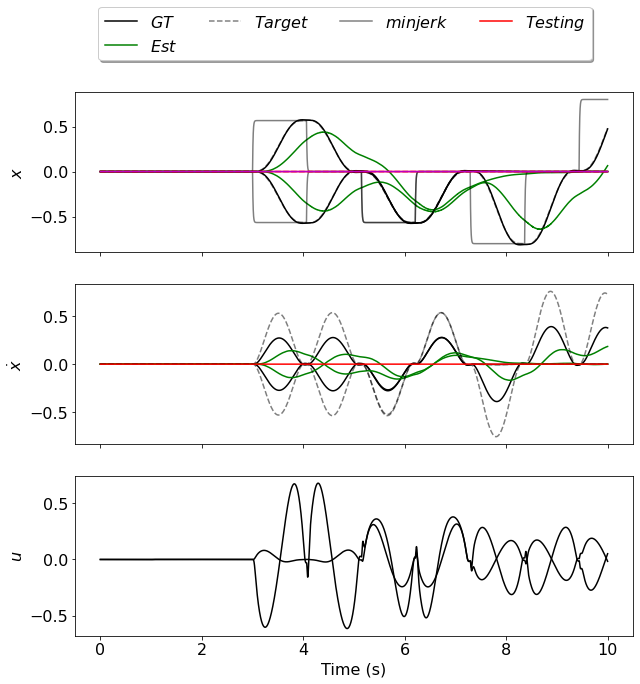

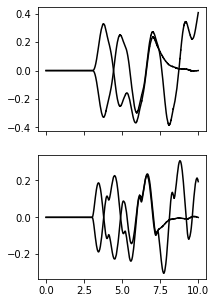

In [1306]:

from collections import OrderedDict

def plot_probes(probes_vis, ind0, indf, est_color='g'):
    ind0 = ind0*1000
    if indf != 1:
        indf = indf*1000

    p, T, Zv, Xv, U, No, Tar, Op, VMR, VwL = probes_vis
    figs, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    # pos
    axs[0].plot(T[ind0:indf], Zv[ind0:indf,0:2], 'k', label='$GT$')
    axs[0].plot(T[ind0:indf], Xv[ind0:indf,0:2], est_color, label='$Est$')
    axs[0].plot(T[ind0:indf], Tar[ind0:indf,0:2], 'k--', alpha=0.5, label='$Target$')
    # axs[0].plot(T[ind0:indf], np.cumsum(Tar[ind0:indf,3])*1e-3, 'm', alpha=0.5, label='$minjerk$')
    axs[0].plot(T[ind0:indf], Tar[ind0:indf,5:7], 'k', alpha=0.5, label='$minjerk$')
    axs[0].plot(T[ind0:indf], No[ind0:indf], 'r', label='$Testing$')
    axs[0].plot(T[ind0:indf], VMR[ind0:indf], 'r--') # VMR
    axs[0].plot(T[ind0:indf], Op[ind0:indf], 'm') # Opaque
    axs[0].set_ylabel('$x$', fontsize=16)
    axs[0].tick_params(axis='both', which='major', labelsize=16)
    # axs[0].set_ylim([-1.1, 1.1])
    

    # vel
    axs[1].plot(T[ind0:indf], Zv[ind0:indf,2:4], 'k', label='$GT$')
    axs[1].plot(T[ind0:indf], Xv[ind0:indf,2:4], est_color, label='$Est$')
    axs[1].plot(T[ind0:indf], Tar[ind0:indf,2:4]/p.scale_vel, 'k--', alpha=0.5, label='$minjerk$')
    axs[1].plot(T[ind0:indf], No[ind0:indf], 'r', label='$Testing$')
    axs[1].set_ylabel('$\dot{x}$', fontsize=16)
    axs[1].tick_params(axis='both', which='major', labelsize=16)
    # axs[1].set_ylim([-1.1, 1.1])

    # ctrl
    axs[2].plot(T[ind0:indf], U[ind0:indf], 'k', label='$GT$')
    axs[2].set_xlabel('Time (s)', fontsize=16)
    axs[2].set_ylabel('$u$', fontsize=16)
    # axs[2].set_ylim([-1.1, 1.1])
    axs[2].tick_params(axis='both', which='major', labelsize=16)

    # Plot pos and vel errs
    fig, ax = plt.subplots(2, 1, figsize=(3, 5), sharex=True)
    ax[0].plot(T[ind0:indf], Zv[ind0:indf,0:2] - Xv[ind0:indf,0:2], 'k', label='$GT$')

    ax[1].plot(T[ind0:indf], Zv[ind0:indf,2:4] - Xv[ind0:indf,2:4], 'k', label='$GT$')
    # ax[1].set_ylim([-1.1, 1.1])
    # ax[0].set_ylim([-1.1, 1.1])
    
    handles, labels = axs[0].get_legend_handles_labels()
    handles2, labels2 = axs[1].get_legend_handles_labels()
    handles.extend(handles2)
    labels.extend(labels2)
    handles, labels = zip(*OrderedDict(zip(handles, labels)).items())
    # Find only unique handles and labels
    unique_handles = []
    unique_labels = []
    for i, label in enumerate(labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handles[i])

    figs.legend(unique_handles, unique_labels, loc='upper center', ncol=4, fontsize=16, bbox_to_anchor=(0.5, 1.01), fancybox=True, shadow=True)
    # Remove duplicates
    

    # p, T, Zv, Xv, U, No, Tar, Op, VMR, VwL = probes_vis
    # thresh_p = 0.05
    # thresh_v = 0.05

    # dt = 1e-3
    no_obs_ind = int(p.no_obs_from*1000)
    # err_vis_pos = np.sqrt(np.sum(((Xv - Zv)[no_obs_ind:-1, 0:2])**2, axis=1))
    # err_vis_vel = np.sqrt(np.sum(((Xv - Zv)[no_obs_ind:-1, 2:4])**2, axis=1))
    # cumperr_P = np.cumsum(err_vis_pos*dt)
    # cumverr_V = np.cumsum(err_vis_vel*dt)

    # # axs[0].plot(T[no_obs_ind:indf], cumperr_P[0:indf-no_obs_ind], 'r', label='$Vis$')
    # try:
    #     # print("Calc", thresh_p,  cumperr_P)
    #     V_p = dt*np.where(cumperr_P<thresh_p)[-1][-1]
    #     V_v = dt*np.where(cumverr_V<thresh_v)[-1][-1]
    # except:
    #     print("No convergence")
    #     V_p = 0
    #     V_v = 0

    # metric = f'Pos:{V_p}, Vel:{V_v}'
    # print(metric)
    # # axs[0].plot(T[no_obs_ind:-1], cumperr_P, 'g', label='$Vis$')
    # # axs[0].plot(T[int(no_obs_ind+V_p*1000)], cumperr_P[int(V_p*1000)], 'ro', label='$Vis$')

    # # axs[1].plot(T[no_obs_ind:-1], cumperr_V, 'g', label='$Vis$')
    # # axs[1].plot(T[int(no_obs_ind+V_v*1000)], cumperr_V[int(V_v*1000)], 'ro', label='$Vis$')
    # # return metric
    # # axs[0].set_xlim([ind0/1000, indf/1000])
    # # axs[1].set_xlim([ind0/1000, indf/1000])
    metric = _get_metric_(Xv, Zv, no_obs_ind)


def _get_metric_(Xv, Zv, no_obs_ind=0):
    thresh_p = 0.05
    thresh_v = 0.05

    dt = 1e-3
    print("No obs ind is ", no_obs_ind)
    err_vis_pos = np.sqrt(np.sum(((Xv - Zv)[no_obs_ind:-1, 0:2])**2, axis=1))
    err_vis_vel = np.sqrt(np.sum(((Xv - Zv)[no_obs_ind:-1, 2:4])**2, axis=1))
    cumperr_P = np.cumsum(err_vis_pos*dt)
    cumverr_V = np.cumsum(err_vis_vel*dt)


    try:
        # print("Calc", thresh_p,  cumperr_P)
        V_p = dt*np.where(cumperr_P<thresh_p)[-1][-1]
        V_v = dt*np.where(cumverr_V<thresh_v)[-1][-1]

    except:
        print("No convergence")
        V_p = 0
        V_v = 0

    metric = [V_p, V_v]
    print(metric)
    return metric


ind0 = 0
indf = 10

plot_probes(probes_vis, ind0, indf, est_color='g')
# get_metrics(probes_vis, Xv, Zv)
# 1.169, 1.182
# 1.123, Vel:1.090
# 1.035, Vel:1.053
# 1.069, 1.027


In [1310]:
seed_list = [47]

for i in range(len(seed_list)):
    p.blindfrom = 1000
    p.seed = seed_list[i]
    probes_vis = Visual_system(p, blindfrom=p.blindfrom, gtc=p.gtc, use_stored_weights=False)
    file_name = f'data\probes_vision_GT_seed{p.seed}.pkl'
    with open(file_name, 'wb') as f:
        pickle.dump(probes_vis, f)

Recurr is  False
Zero weights
Theta_s: 0.1 Qs: 2
Ctrl,  0
Ctrl,  1
Ground Truth Control
Total dim in adapt:  10  and simulation time is  1000


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Hit
Hit
Hit
Hit
Hit
 Reach num: 5 Hits: 5.00 Trials: 2.00 targ_rad 0.80 Last rt: 1.07 pos_err: 0.01 vel_err 0.01 global_time 5.21
Hit
Hit
Hit
Hit
Hit
 Reach num: 10 Hits: 10.00 Trials: 5.00 targ_rad 0.80 Last rt: 1.08 pos_err: 0.01 vel_err 0.01 global_time 10.58
Hit
Hit
Hit
Hit
Hit
 Reach num: 15 Hits: 15.00 Trials: 7.00 targ_rad 0.80 Last rt: 1.06 pos_err: 0.01 vel_err 0.01 global_time 15.93
Hit
Hit
Hit
Hit
Hit
 Reach num: 20 Hits: 20.00 Trials: 10.00 targ_rad 0.80 Last rt: 1.07 pos_err: 0.01 vel_err 0.01 global_time 21.30
Hit
Hit
Hit
Hit
Hit
 Reach num: 25 Hits: 25.00 Trials: 12.00 targ_rad 0.80 Last rt: 1.06 pos_err: 0.01 vel_err 0.01 global_time 26.65
Hit
Hit
Hit
Hit
Hit
 Reach num: 30 Hits: 30.00 Trials: 15.00 targ_rad 0.80 Last rt: 1.07 pos_err: 0.01 vel_err 0.01 global_time 32.02
Hit
Hit
Hit
Hit
Hit
 Reach num: 35 Hits: 35.00 Trials: 17.00 targ_rad 0.80 Last rt: 1.07 pos_err: 0.01 vel_err 0.01 global_time 37.38
Hit
Hit
Hit
Hit
Hit
 Reach num: 40 Hits: 40.00 Trials: 20.00 targ_ra

No obs ind is  995000
[1.161, 1.155]


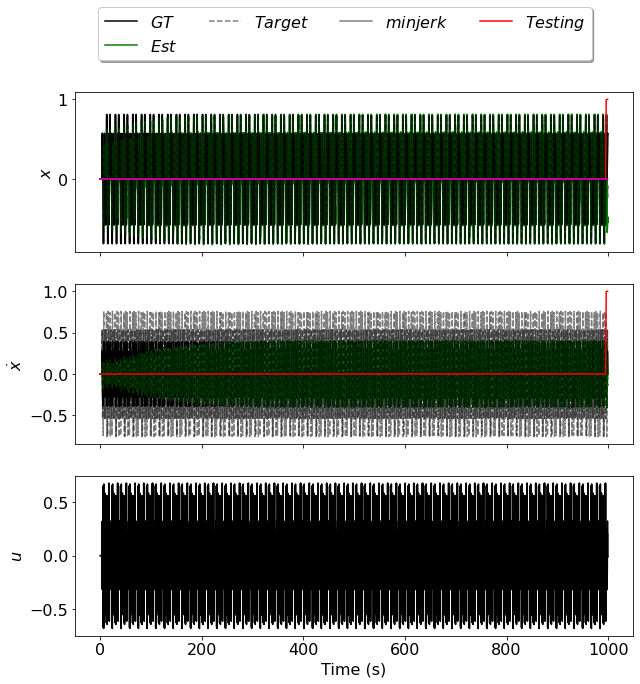

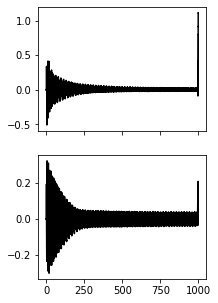

In [1311]:
probes_vis = load_model('data\probes_vision_GT_seed47.pkl')
ind0 = 0
indf = -1
p, T, Zv, Xv, U, No, Tar, Op, VMR, VwL = probes_vis
plot_probes(probes_vis, ind0, indf, est_color='g')

No observations: 995000
(995000, 4) (995000, 2)
(x0)' = 3.998 x2 + 0.002 sin(1 x2)
(x1)' = 3.998 x3 + 0.002 sin(1 x3)
(x2)' = -41.201 1 + -0.593 x0 + -0.388 x1 + -0.626 x2 + -1.854 u0 + -1.108 u1 + 4.806 x0 x3 + -4.748 x1 x2 + -0.562 x1 u0 + -0.781 x1 u1 + 10.077 x2^2 + 1.701 x2 x3 + 1.989 u0^2 + 9.090 u1^2 + 0.622 sin(1 x0) + 0.392 sin(1 x1) + 0.625 sin(1 x2) + 19.288 cos(1 x2) + -0.482 cos(1 x3) + 0.261 sin(1 u0) + 4.081 cos(1 u0) + 18.313 cos(1 u1)
(x3)' = -14.806 1 + 0.344 x0 + 0.704 x1 + 0.187 x2 + -0.615 x3 + 1.436 u0 + -1.695 u1 + -0.655 x0 x3 + 0.743 x0 u0 + 0.748 x0 u1 + -0.852 x1^2 + 0.645 x1 x2 + 0.466 x1 u0 + -0.263 x1 u1 + 12.826 x2^2 + -0.913 x2 x3 + -31.574 x3^2 + 1.334 u0^2 + 25.198 u1^2 + -0.369 sin(1 x0) + -0.795 sin(1 x1) + -1.825 cos(1 x1) + -0.188 sin(1 x2) + 26.611 cos(1 x2) + 0.618 sin(1 x3) + -63.570 cos(1 x3) + -0.514 sin(1 u0) + 2.695 cos(1 u0) + -2.084 sin(1 u1) + 50.894 cos(1 u1)
Initial condition: [[ 1.51933504e-04 -4.12370663e-01  2.04773731e-04  3.9042492

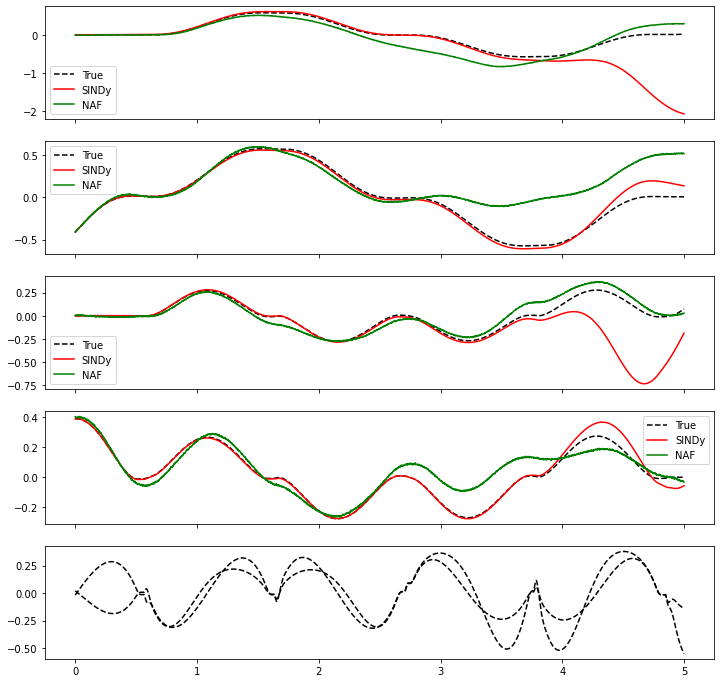

In [1178]:
import pysindy as ps

no_obs = int(p.no_obs_from/p.dt)
print(f"No observations: {no_obs}")
train_data = Zv[:no_obs]
test_data = Zv[no_obs:]
x_hat_naf = Xv[no_obs:]

u_train = U[:no_obs]
u_test = U[no_obs:]

print(train_data.shape, u_train.shape)


def give_sindy_pred(train_data, test_data, u_train, u_test, test_est, to_plot = False):
    dt = 1e-3
    poly_library = ps.PolynomialLibrary()
    fourier_library = ps.FourierLibrary()
    combined_library = poly_library + fourier_library
    model3 = ps.SINDy(
        feature_library=combined_library,
        # feature_names=feature_names
        )
    model3.fit(train_data, u=u_train, t=dt)
    model3.print()

    x_i = test_data[0].reshape(1,4)
    time_data = np.arange(0, test_data.shape[0]*dt, dt)

    print(f"Initial condition: {x_i} and of shape {x_i.shape}")
    N = test_data.shape[0]
    x_sindy = np.zeros((N, 4))

    for i in range(5000):
        # print(i)
        try:
            x_dot_out = model3.predict(x_i, u=u_test[i].reshape(1,2))
            x_i = x_i + x_dot_out*dt
            x_sindy[i] = x_i
        except:
            print(f"x_i: {x_i} \n")
            print("SINDy failed")
            break
    # Metrics 
    

    # metric = f"Pos: SINDy: {cerr_hit_pos_sindy}, NAF: {cerr_hit_pos_naf} \n Vel: SINDy: {cerr_hit_vel_sindy}, NAF: {cerr_hit_vel_naf}"

    if to_plot:
        # Plot the results
        fig, ax = plt.subplots(5, 1, figsize=(12, 12), sharex=True)
        for i in range(4):
            ax[i].plot(time_data, test_data[:, i], 'k--', label="True")
            ax[i].plot(time_data, x_sindy[:, i], 'r',label="SINDy")
            ax[i].plot(time_data, test_est[:, i], 'g',label="NAF")
            ax[i].legend()
        ax[4].plot(time_data, u_test, 'k--', label="True")

    return x_sindy


x_hat_sindy = give_sindy_pred(train_data, test_data, u_train, u_test, x_hat_naf, to_plot = False)




In [1181]:

# get metrics from naf and sindy
print("Metrics from Sindy")
metric_sindy = _get_metric_(x_hat_sindy, test_data, 0)

print("\nMetrics from NAF")
metric_naf = _get_metric_(x_hat_naf, test_data, 0)


Metrics from Sindy
No obs ind is  0
Pos:2.4290000000000003, Vel:3.883

Metrics from NAF
No obs ind is  0
Pos:1.622, Vel:1.461


In [1316]:


# ind0 = -10
# indf = -1

# Metric_iter = []
# iter_list = [0, 1, 2, 3, 4]

# for i, this_seed in enumerate(seed_list):
#     params, probes_est = load_model(f"data_saves\pend_tf1005_s0.01_qs4_u0.01_qu4_recurrFalse_GTCFalse_n1000_iter{iter_list[i]}.pkl")
#     # model_q.plot_states_nengo(params, probes_nengo, ind0, indf, True)
#     time, Q, U, Targ, Minj, Z, Xest, E, C, NO = probes_est
#     no_obs = int(params.no_obs_from/params.dt)
#     print(no_obs)
    
#     train_data = Z[:no_obs]
#     test_data = Z[no_obs:]
#     test_zest = Xest[no_obs:]

#     u_train = U[:no_obs]
#     u_test = U[no_obs:]
#     metric_str, metric_list = give_sindy_metric(train_data, test_data, u_train, u_test, test_zest, to_plot = True)

#     print(metric_str)
#     Metric_iter.append(metric_list)


seed_list = [43, 44, 45, 46, 47]
Metric_iter = []

for i in range(len(seed_list)):
    file_name = f'data\probes_vision_GT_seed{seed_list[i]}.pkl'
    print("\n" , file_name)
    probes_vis = load_model(file_name)
    p, T, Zv, Xv, U, No, Tar, Op, VMR, VwL = probes_vis
    
    no_obs = int(p.no_obs_from/p.dt)

    train_data = Zv[:no_obs]
    test_data = Zv[no_obs:]
    x_hat_naf = Xv[no_obs:]

    u_train = U[:no_obs]
    u_test = U[no_obs:]

    x_hat_sindy = give_sindy_pred(train_data, test_data, u_train, u_test, x_hat_naf, to_plot = False)
    print("Metrics from Sindy")
    metric_sindy = _get_metric_(x_hat_sindy, test_data, 0) #[V_p, V_v]

    print("\nMetrics from NAF")
    metric_naf = _get_metric_(x_hat_naf, test_data, 0) #[V_p, V_v]

    this_metric = metric_sindy + metric_naf
    Metric_iter.append(this_metric)




 data\probes_vision_GT_seed43.pkl
(x0)' = 3.997 x2 + 0.003 sin(1 x2)
(x1)' = 3.997 x3 + 0.003 sin(1 x3)
(x2)' = -32.467 1 + -0.556 x0 + -0.322 x1 + -0.847 x2 + -1.855 u0 + -1.162 u1 + 5.895 x0 x3 + -0.114 x0 u1 + -5.922 x1 x2 + -0.541 x1 u0 + -0.759 x1 u1 + 0.465 x2^2 + 1.605 x2 x3 + 2.093 u0^2 + 14.198 u1^2 + 0.586 sin(1 x0) + 0.317 sin(1 x1) + 0.846 sin(1 x2) + -0.418 cos(1 x3) + 0.263 sin(1 u0) + 4.292 cos(1 u0) + 0.059 sin(1 u1) + 28.594 cos(1 u1)
(x3)' = 0.817 1 + 0.378 x0 + 0.691 x1 + 0.324 x2 + -0.596 x3 + 1.384 u0 + -1.653 u1 + 0.372 x0^2 + -2.742 x0 x3 + 0.759 x0 u0 + 0.769 x0 u1 + -1.410 x1^2 + 2.749 x1 x2 + 0.464 x1 u0 + -0.275 x1 u1 + 3.247 x2^2 + -0.885 x2 x3 + -30.853 x3^2 + 1.277 u0^2 + 26.520 u1^2 + -0.407 sin(1 x0) + 0.822 cos(1 x0) + -0.780 sin(1 x1) + -3.000 cos(1 x1) + -0.325 sin(1 x2) + 7.193 cos(1 x2) + 0.604 sin(1 x3) + -62.010 cos(1 x3) + -0.459 sin(1 u0) + 2.597 cos(1 u0) + -2.125 sin(1 u1) + 53.582 cos(1 u1)
Initial condition: [[-7.60155362e-01  2.38424021e-0

c:\Users\Nat\Documents\Code\Thesis\two_link_AUG_2023\pysindy\utils\axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
c:\Users\Nat\Anaconda3\envs\ndl\lib\site-packages\ipykernel_launcher.py:106: RuntimeWarning: overflow encountered in square


x_i: [[-8.23587021e+099 -2.07553109e+089 -3.77334248e+202 -9.84043538e+190]] 

SINDy failed
Metrics from Sindy
No obs ind is  0
[1.498, 2.056]

Metrics from NAF
No obs ind is  0
[1.495, 1.598]

 data\probes_vision_GT_seed45.pkl
(x0)' = 3.998 x2 + 0.002 sin(1 x2)
(x1)' = 3.997 x3 + 0.003 sin(1 x3)
(x2)' = -0.498 x0 + -0.295 x1 + -0.414 x2 + 0.339 x3 + -1.859 u0 + -0.420 u1 + 1.396 x0 x3 + -0.106 x0 u1 + -0.617 x1^2 + -1.397 x1 x2 + -0.543 x1 u0 + -0.767 x1 u1 + 1.639 x2 x3 + -0.642 x3^2 + 1.918 u0^2 + 0.524 sin(1 x0) + 0.289 sin(1 x1) + -1.285 cos(1 x1) + 0.411 sin(1 x2) + -1.010 cos(1 x2) + -0.348 sin(1 x3) + -1.639 cos(1 x3) + 0.269 sin(1 u0) + 3.934 cos(1 u0) + -0.693 sin(1 u1)
(x3)' = 2.187 1 + 0.361 x0 + 0.612 x1 + 0.166 x2 + -1.977 x3 + 1.463 u0 + -1.504 u1 + -4.977 x0 x3 + 0.751 x0 u0 + 0.720 x0 u1 + -0.743 x1^2 + 4.964 x1 x2 + 0.468 x1 u0 + -0.243 x1 u1 + -0.336 x2^2 + -0.926 x2 x3 + -16.535 x3^2 + 1.570 u0^2 + 14.568 u1^2 + -0.386 sin(1 x0) + -0.693 sin(1 x1) + -1.588 cos(1 x1)

c:\Users\Nat\Documents\Code\Thesis\two_link_AUG_2023\pysindy\utils\axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
c:\Users\Nat\Anaconda3\envs\ndl\lib\site-packages\ipykernel_launcher.py:106: RuntimeWarning: overflow encountered in square


x_i: [[-9.80838276e+135 -2.78172891e+137 -2.82878018e+276 -8.02395566e+277]] 

SINDy failed
Metrics from Sindy
No obs ind is  0
[2.157, 2.515]

Metrics from NAF
No obs ind is  0
[1.413, 1.237]

 data\probes_vision_GT_seed46.pkl
(x0)' = 3.998 x2 + 0.002 sin(1 x2)
(x1)' = 3.998 x3 + 0.002 sin(1 x3)
(x2)' = -0.382 1 + -0.561 x0 + -0.543 x1 + -0.661 x2 + -1.660 x3 + -1.878 u0 + -1.145 u1 + 5.136 x0 x3 + -5.149 x1 x2 + -0.574 x1 u0 + -0.796 x1 u1 + 1.613 x2 x3 + -1.333 x3^2 + 2.207 u0^2 + 0.585 sin(1 x0) + 0.558 sin(1 x1) + 0.653 sin(1 x2) + -1.067 cos(1 x2) + 1.684 sin(1 x3) + -3.098 cos(1 x3) + 0.286 sin(1 u0) + 4.547 cos(1 u0) + 0.038 sin(1 u1)
(x3)' = -16.348 1 + 0.346 x0 + 0.647 x1 + 0.195 x2 + -1.016 x3 + 1.433 u0 + -2.180 u1 + 0.857 x0^2 + 1.689 x0 x3 + 0.775 x0 u0 + 0.743 x0 u1 + -1.807 x1^2 + -1.697 x1 x2 + 0.473 x1 u0 + -0.276 x1 u1 + -0.278 x2^2 + -0.922 x2 x3 + -19.494 x3^2 + 1.646 u0^2 + 26.754 u1^2 + -0.373 sin(1 x0) + 1.852 cos(1 x0) + -0.734 sin(1 x1) + -3.841 cos(1 x1) + -0

c:\Users\Nat\Documents\Code\Thesis\two_link_AUG_2023\pysindy\utils\axes.py:83: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
c:\Users\Nat\Anaconda3\envs\ndl\lib\site-packages\ipykernel_launcher.py:106: RuntimeWarning: overflow encountered in square


x_i: [[-8.15144866e+101 -1.29427579e+103 -1.29036181e+208 -2.04867081e+209]] 

SINDy failed
Metrics from Sindy
No obs ind is  0
[2.185, 2.169]

Metrics from NAF
No obs ind is  0
[1.344, 1.242]

 data\probes_vision_GT_seed47.pkl
(x0)' = 3.998 x2 + 0.002 sin(1 x2)
(x1)' = 3.944 x3 + -0.113 x0 x3 + 0.113 x1 x2 + 0.057 sin(1 x3)
(x2)' = 13.390 1 + -0.533 x0 + -0.331 x1 + -0.724 x2 + -0.634 x3 + -1.799 u0 + -0.745 u1 + -1.236 x0 x3 + 1.230 x1 x2 + -0.573 x1 u0 + -0.802 x1 u1 + 1.632 x2 x3 + -7.997 x3^2 + 2.018 u0^2 + 0.557 sin(1 x0) + 0.330 sin(1 x1) + 0.730 sin(1 x2) + -0.979 cos(1 x2) + 0.645 sin(1 x3) + -16.570 cos(1 x3) + 0.204 sin(1 u0) + 4.160 cos(1 u0) + -0.366 sin(1 u1)
(x3)' = -12.005 1 + 0.362 x0 + 0.666 x1 + -1.792 x3 + 1.458 u0 + -1.643 u1 + -2.726 x0 x3 + 0.748 x0 u0 + 0.730 x0 u1 + -0.845 x1^2 + 2.717 x1 x2 + 0.472 x1 u0 + -0.250 x1 u1 + 11.133 x2^2 + -0.909 x2 x3 + -32.279 x3^2 + 1.501 u0^2 + 26.017 u1^2 + -0.388 sin(1 x0) + -0.754 sin(1 x1) + -1.804 cos(1 x1) + 23.231 cos(1 

Mean and std for the four seeds: [1.851  2.4316 1.3892 1.3146] and [0.31511458 0.2992401  0.13157264 0.15347782]


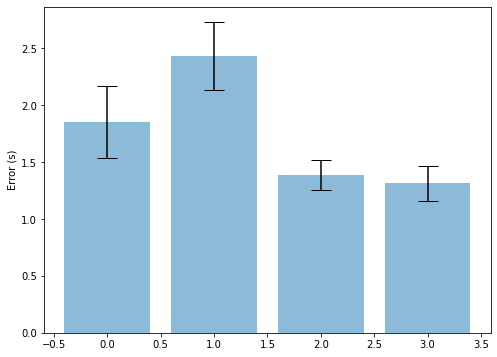

In [1322]:
np.array(Metric_iter)

# Plot the mean and std of the metrics
Metric_iter = np.array(Metric_iter)
Metric_iter.shape

# bar plot (4 bars in total)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.bar(np.arange(4), Metric_iter.mean(axis=0), yerr=Metric_iter.std(axis=0), align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Error (s)')

# GT
print(f"Mean and std for the four seeds: {Metric_iter.mean(axis=0)} and {Metric_iter.std(axis=0)}")


Text(0.5, 1.0, '(c) Two-link')

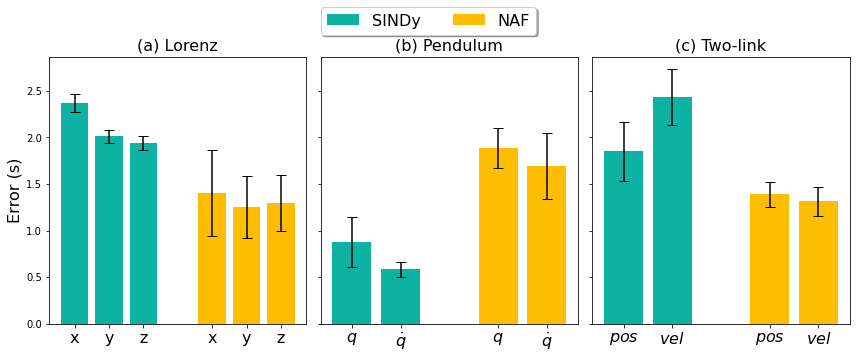

In [1357]:

# Lor GT
lor_sindy_mean = [2.367, 2.011, 1.937]
lor_naf_mean = [1.405, 1.252, 1.294]
lor_sindy_std = [0.099, 0.068, 0.076]
lor_naf_std = [0.458, 0.331, 0.302]

# pend GT
pend_sindy_mean = [0.879, 0.5864]
pend_naf_mean = [1.8878, 1.695]
pend_sindy_std = [0.270, 0.081]
pend_naf_std = [0.216, 0.353]

## twolink GT
two_link_sindy_mean = [1.851, 2.4316]
two_link_naf_mean = [1.3892, 1.3146]
two_link_sindy_std = [0.31511458, 0.2992401]
two_link_naf_std = [0.13157264, 0.15347782]

# Bar plots 3 subpolots for each task Sindy and NAF in different colors 
sindy_color = "#0db2a2"
naf_color = "#febd01"

fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
# xaxis should be [x, y, z, x, y, z] but space between first three and last three
lor_x_sindy = np.arange(len(lor_sindy_mean))
lor_x_naf = np.arange(len(lor_naf_mean)) + len(lor_x_sindy) + 1
axs[0].bar(lor_x_sindy, lor_sindy_mean, yerr=lor_sindy_std, align='center', ecolor='black', capsize=5, color=sindy_color)
axs[0].bar(lor_x_naf, lor_naf_mean, yerr=lor_naf_std, align='center', ecolor='black', capsize=5, color=naf_color)
# make xaxis labels for the first three and last three as ['x', 'y', 'z', 'x', 'y', 'z']
axs[0].set_xticks(np.concatenate((lor_x_sindy, lor_x_naf)))
lor_x_labels = ['x', 'y', 'z', 'x', 'y', 'z']
axs[0].set_xticklabels(lor_x_labels, fontsize=16)
axs[0].set_ylabel('Error (s)', fontsize=16)

# pend
pend_x_sindy = np.arange(len(pend_sindy_mean))
pend_x_naf = np.arange(len(pend_naf_mean)) + len(pend_x_sindy) + 1
axs[1].bar(pend_x_sindy, pend_sindy_mean, yerr=pend_sindy_std, align='center', ecolor='black', capsize=5, color=sindy_color)
axs[1].bar(pend_x_naf, pend_naf_mean, yerr=pend_naf_std, align='center', ecolor='black', capsize=5, color=naf_color)
axs[1].set_xticks(np.concatenate((pend_x_sindy, pend_x_naf)))
# make xaxis labels for the first two and last two as ['$q$', '$\dot{q}$', '$q$', '$\dot{q}$']
pend_x_labels = ['$q$', '$\dot{q}$', '$q$', '$\dot{q}$']
axs[1].set_xticklabels(pend_x_labels, fontsize=16)

# twolink
two_link_x_sindy = np.arange(len(two_link_sindy_mean))
two_link_x_naf = np.arange(len(two_link_naf_mean)) + len(two_link_x_sindy) + 1
axs[2].bar(two_link_x_sindy, two_link_sindy_mean, yerr=two_link_sindy_std, align='center', ecolor='black', capsize=5, color=sindy_color)
axs[2].bar(two_link_x_naf, two_link_naf_mean, yerr=two_link_naf_std, align='center', ecolor='black', capsize=5, color=naf_color)
axs[2].set_xticks(np.concatenate((two_link_x_sindy, two_link_x_naf)))
# make xaxis labels for the first two and last two as ['$q$', '$\dot{q}$', '$q$', '$\dot{q}$']
two_link_x_labels = ['$pos$', '$vel$', '$pos$', '$vel$']
axs[2].set_xticklabels(two_link_x_labels, fontsize=16)

fig.legend(['SINDy', 'NAF'], loc='upper center', ncol=2, fontsize=16, bbox_to_anchor=(0.5, 1.01), fancybox=True, shadow=True)
fig.tight_layout()
# Add gap between legend and subplots
fig.subplots_adjust(top=0.85)

# Add title to each subplot
axs[0].set_title('(a) Lorenz', fontsize=16)
axs[1].set_title('(b) Pendulum', fontsize=16)
axs[2].set_title('(c) Two-link', fontsize=16)


In [140]:
# # save Vw and probes_vis
# import pickle
# file_name = f'VwL_Th_s_{p.theta_s}_Th_u_{p.theta_u}_Qs_{p.qs}_Qu_{p.qu}_Lr_{p.Lr}_recurr_{p.recurr}_blindfrom_{p.blindfrom}_n_neurons_{p.n_neurons}_targ_rad_{p.targ_rad}_seed{p.seed}.pkl'
# with open(file_name, 'wb') as f:
#     pickle.dump(VwL, f)
# # 
# file_name = f'probes_vis_Th_s_{p.theta_s}_Th_u_{p.theta_u}_Qs_{p.qs}_Qu_{p.qu}_Lr_{p.Lr}_recurr_{p.recurr}_blindfrom_{p.blindfrom}_n_neurons_{p.n_neurons}_targ_rad_{p.targ_rad}_seed{p.seed}.pkl'
# with open(file_name, 'wb') as f:
#     pickle.dump(probes_vis, f)
# p.no_obs_from

495

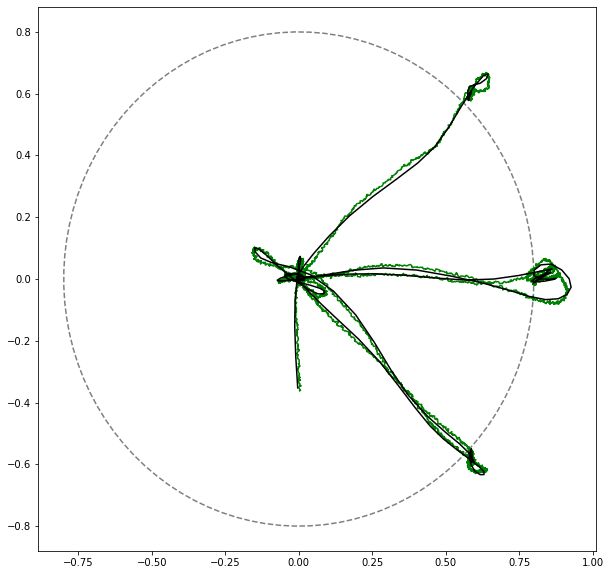

In [148]:
# ind0 = 50
# indf = 25000

ind0 = ind0*1000
indf = indf*1000

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# ax.plot(T[ind0:indf], Zv[ind0:indf,0:2], 'k', label='$GT$')
# ax.plot(T[ind0:indf], Xv[ind0:indf,0:2], 'g', label='$Est$')
# plot a circle of radius 0.5
theta = np.linspace(0, 2*np.pi, 100)
r = 0.8
x1 = r*np.cos(theta); y1 = r*np.sin(theta)
ax.plot(x1, y1, 'k--', alpha=0.5, label='$Target$')
ax.plot(Xv[ind0:indf,0], Xv[ind0:indf,1], 'g', label='$Est$')
ax.plot(Zv[ind0:indf:50,0], Zv[ind0:indf:50,1], 'k', label='$GT$')
# ax.plot(0,0, 'kx')

### Visual try

In [150]:
def Visual_minj_system(p, blindfrom, gtc, use_stored_weights=False):
    model = nengo.Network(seed=p.seed)
    # print(p)
    with model:
        p.blindfrom = blindfrom
        p.recurr = False     ; print("Recurr is ", p.recurr)
        p.gtc = gtc
        p.no_obs_from = p.blindfrom - 3 

        p.start_from = 1
        p.n_neurons = 2000

        p.theta = 0
        p.rot_start = 3
        p.rot_end   = 5


        # print(f"Rotation starts at {p.rot_start} and ends at {p.rot_end} and angle is {p.theta}")
        
        
                
        
        u_scale = p.max_torque
        
        if use_stored_weights:
            print("Using stored weights")
            weights_folder = 'data/'
            Vwl_file_name = 'VwL_Th_s_0.02_Th_u_0.02_Qs_2_Qu_3_Lr_0.0001_recurr_False_blindfrom_200_n_neurons_2000_targ_rad_0.5.pkl'
            
            with open(weights_folder+Vwl_file_name, 'rb') as f:
                Xvw = pickle.load(f)
        else:
            print("Zero weights")
            V1 = np.zeros((1, p.n_neurons))
            V2 = np.zeros((1, p.n_neurons))
            V3 = np.zeros((1, p.n_neurons))
            V4 = np.zeros((1, p.n_neurons))

            Xvw = [V1, V2, V3, V4]; 
        
        
        
        env = TE.ArmNet(p); 
                            
        V = TE.EstNet(p, Xw=Xvw)
        
        
        nengo.Connection(env.vision, V.Z, synapse=None); 
        
        nengo.Connection(env.u_tot, V.U, transform=1/u_scale, synapse=None)
        
        if p.gtc:
            print('Ground Truth Control')
            nengo.Connection(env.vision, env.u, transform=-1)
            nengo.Connection(env.arm[0:4], env.u_tot[2:6])
        else:        
            print('Estimation Control')
            
            
            nengo.Connection(V.X, env.u, transform=-1)        
            nengo.Connection(env.arm[0:4], env.u_tot[2:6])
            
        nengo.Connection(env.tm_node[0:2], env.u[:2]);# print("Minj vel is connected")

        VwL_ = []
        for i in range(p.Zdim):
            VwL_.append(nengo.Probe(V.conn[i], "weights", sample_every=p.blindfrom-5))

        Zv_ = nengo.Probe(env.vision, synapse=0.01)
        Up_ = nengo.Probe(V.U, synapse=0.01)
        Tar_ = nengo.Probe(env.tm_node, synapse=0.01)
        
        Xv_ = nengo.Probe(V.X, synapse=0.01)
        no_obs = nengo.Probe(V.no_obs, synapse=0.01)
        Op_ = nengo.Probe(env.opaque, synapse=0.01) #Not connected this simulation
        VMRsig_ = nengo.Probe(env.rot)
        
        
        if p.AC:
            print("Adaptive control is ON")
            
            Aw = 1e-6*np.random.rand(2, 500)
            aconn = nengo.Connection(env.u_adapt.neurons, env.u_tot[:2], transform=Aw)
            aconn.learning_rule_type = nengo.PES(learning_rate=1e-5)
            
            def err_fun(t, x):
                return (x[0:2]+x[2:4])*(1-x[4])
            
            err_traj = nengo.Node(err_fun, size_in = 5)
            nengo.Connection(V.no_obs, err_traj[4])
            nengo.Connection(V.X, err_traj[:4], transform=-1) # The error is in the observation plane
            nengo.Connection(env.tm_node[:2], err_traj[:2])

            nengo.Connection(env.tm_node[2:4], err_traj[2:4])

            nengo.Connection(err_traj, aconn.learning_rule, transform = -1)    
    #         nengo.Connection(env.u, aconn.learning_rule, transform = -1) 

            # Instead of prop, P.X goes inside the u_adapt
            nengo.Connection(V.X, env.u_adapt)
        
        print("Total dim in adapt: ", p.Zdim*p.qs+ p.Udim*p.qu," and simulation time is ", p.blindfrom)
        with nengo.Simulator(model) as sim:
            sim.run(p.blindfrom)
                
        T = sim.trange()
        Zv = sim.data[Zv_]
        Xv = sim.data[Xv_]
        U = sim.data[Up_]
        No = sim.data[no_obs]
        Tar = sim.data[Tar_]
        Op = sim.data[Op_]
        VMR = sim.data[VMRsig_]
        VwL = []

        # Weights
        for i in range(p.Zdim):
            VwL.append(sim.data[VwL_[i]][0])

        return p, T, Zv, Xv, U, No, Tar, Op, VMR, VwL

In [1221]:
p.kp = 200
p.kd = 40
        
p.theta_s = 0.01
p.qs = 3

p.theta_u = 0.01
p.qu = 2
p.Lr = 1e-4

p.blindfrom = 500
p.reach_slow = True;  print("Reach slow is ", p.reach_slow)
p.targ_rad = 0.75; print("Target radius is ", p.targ_rad)

p.AC = True 
p.seed = 49
# Seed numpy
np.random.seed(p.seed)

p.gtc = False

probes_vis_mj = Visual_minj_system(p, blindfrom=p.blindfrom, gtc=p.gtc, use_stored_weights=False)


Reach slow is  True
Target radius is  0.75
Recurr is  False
Zero weights
Rotation starts at 3 and ends at 5 and angle is 0
Theta_s: 0.01 Qs: 2
Ctrl,  0
Ctrl,  1
Estimation Control
Adaptive control is ON
Total dim in adapt:  10  and simulation time is  500


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Hit 

targ_rad: 0.07500000000000001 and reach_slow_factor: 0.10
 Reach num: 5 Hits: 1.00 Trials: 2.00 targ_rad 0.08 Last rt: 1.00 pos_err: 0.13 vel_err 1.25
 Reach num: 10 Hits: 1.00 Trials: 5.00 targ_rad 0.08 Last rt: 1.00 pos_err: 0.36 vel_err 0.39
 Reach num: 15 Hits: 1.00 Trials: 7.00 targ_rad 0.08 Last rt: 1.00 pos_err: 0.27 vel_err 0.13
 Reach num: 20 Hits: 1.00 Trials: 10.00 targ_rad 0.08 Last rt: 1.00 pos_err: 0.14 vel_err 0.11
 Reach num: 25 Hits: 1.00 Trials: 12.00 targ_rad 0.08 Last rt: 1.00 pos_err: 0.08 vel_err 0.09
 Reach num: 30 Hits: 1.00 Trials: 15.00 targ_rad 0.08 Last rt: 1.00 pos_err: 0.08 vel_err 0.09
 Reach num: 35 Hits: 1.00 Trials: 17.00 targ_rad 0.08 Last rt: 1.00 pos_err: 0.08 vel_err 0.12
 Reach num: 40 Hits: 1.00 Trials: 20.00 targ_rad 0.08 Last rt: 1.00 pos_err: 0.06 vel_err 0.08
 Reach num: 45 Hits: 1.00 Trials: 22.00 targ_rad 0.08 Last rt: 1.00 pos_err: 0.08 vel_err 0.03
 Reach num: 50 Hits: 1.00 Trials: 25.00 targ_rad 0.08 Last rt: 1.00 pos_err: 0.08 vel

Pos:0.972, Vel:1.079


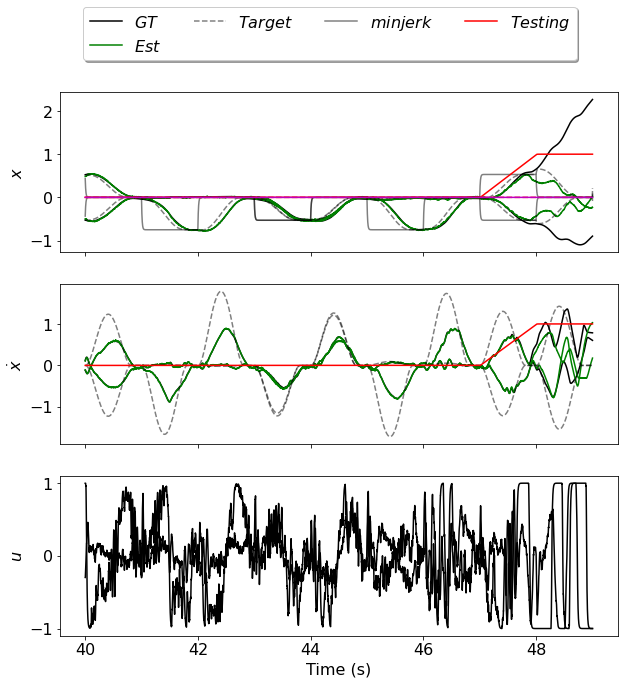

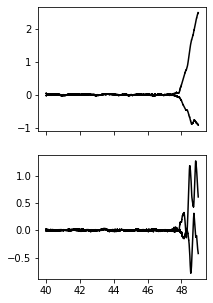

In [3437]:
ind0 =   -10
indf =   -1
plot_probes(probes_vis_mj, ind0, indf, est_color='g')

In [1226]:
p, T, Zv, Xv, U, No, Tar, Op, VMR, VwL = probes_vis_mj

In [1227]:
# save Vw and probes_vis
import pickle
file_name = f'VwL_Th_s_{p.theta_s}_Th_u_{p.theta_u}_Qs_{p.qs}_Qu_{p.qu}_Lr_{p.Lr}_recurr_{p.recurr}_blindfrom_{p.blindfrom}_n_neurons_{p.n_neurons}_targ_rad_{p.targ_rad}_seed{p.seed}_minjvel.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(VwL, f)
# 
file_name = f'probes_vis_Th_s_{p.theta_s}_Th_u_{p.theta_u}_Qs_{p.qs}_Qu_{p.qu}_Lr_{p.Lr}_recurr_{p.recurr}_blindfrom_{p.blindfrom}_n_neurons_{p.n_neurons}_targ_rad_{p.targ_rad}_seed{p.seed}_minjvel.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(probes_vis_mj, f)
p.no_obs_from

497

### VMR

In [1183]:
def VMR_fun(p, blindfrom, gtc, use_stored_weights=False):
    model = nengo.Network(seed=p.seed)
    # print(p)
    with model:
        p.blindfrom = blindfrom
        p.recurr = False     ; print("Recurr is ", p.recurr)
        p.gtc = gtc
        p.no_obs_from = p.blindfrom - 3 

        p.start_from = 1
        p.n_neurons = 2000



        # print(f"Rotation starts at {p.rot_start} and ends at {p.rot_end} and angle is {p.theta}")
        
        
                
        
        u_scale = p.max_torque
        
        if use_stored_weights:
            print("Using stored weights")
            weights_folder = 'data/'
            Vwl_file_name = 'VwL_Th_s_0.1_Th_u_0.1_Qs_2_Qu_1_Lr_0.0001_recurr_False_blindfrom_500_n_neurons_2000_targ_rad_0.8_seed49.pkl'
            
            with open(weights_folder+Vwl_file_name, 'rb') as f:
                Xvw = pickle.load(f)

            # Pwl_file_name = 'PwL_Th_s_0.01_Th_u_0.01_Qs_2_Qu_1_Lr_0.0001_recurr_False_blindfrom_500_n_neurons_2000_targ_rad_0.75.pkl'
            # with open(weights_folder+Pwl_file_name, 'rb') as f:
            #     Xpw = pickle.load(f)

            [Xvw, Xpw, Hw, Aw] = pickle.load(open(weights_folder+'VMR_Vwl_n_Pwl_change.pkl', 'rb'))
            
            # Hw = np.ones((p.Zdim, 1000))*1e-6
            # Aw = 1e-6*np.random.rand(2, p.a_neurons)


        else:
            print("Zero weights")
            V1 = np.zeros((1, p.n_neurons))
            V2 = np.zeros((1, p.n_neurons))
            V3 = np.zeros((1, p.n_neurons))
            V4 = np.zeros((1, p.n_neurons))

            Xvw = [V1, V2, V3, V4]; 
        
            P1 = np.zeros((1, p.n_neurons))
            P2 = np.zeros((1, p.n_neurons))
            P3 = np.zeros((1, p.n_neurons))
            P4 = np.zeros((1, p.n_neurons))

            Xpw = [P1, P2, P3, P4] 
            Aw = 1e-6*np.random.rand(2, p.a_neurons)
        
        env = TE.ArmNet(p); 
        
        # Vision
        V = TE.EstNet(p, Xw=Xvw, no_obs=False)
        nengo.Connection(env.vision, V.Z); 
        nengo.Connection(env.u_tot, V.U, transform=1/u_scale)

        # Proprioception
        P = TE.EstNet(p, Xw=Xpw, no_obs=False)
        nengo.Connection(env.prop, P.Z, synapse=None); 
        nengo.Connection(env.u_tot, P.U, transform=1/u_scale)
        
        
        
        if p.gtc:
            print('Ground Truth Control')
            nengo.Connection(env.vision[:2], env.u[:2], transform=-p.targ_to_cart_scale)
            nengo.Connection(env.vision[2:4], env.u[2:4], transform=-p.scale_vel)
            
            nengo.Connection(env.arm[0:4], env.u_tot[2:6])
            H = nengo.Node(size_in=4)
            nengo.Connection(env.vision, H)
        else:        
            print('Estimation Control')

            def prop_scale(x):
                q1_s, q2_s, dq1_s, dq2_s = x
                #This scaling have to be fixed if different radius of reach
                q1 = ((q1_s +1)* (1.0814649+0.52302206)/2) - 0.15638416 
                q2 = ((q2_s +1)* (2.65949297-1.41167524)/2) + 1.41167524 
                dq1 = ((dq1_s +1)* (1.39191433+1.3713473)/2) - 1.3713473 
                dq2 = ((dq2_s +1)* (1.355404+1.36787882)/2) - 1.36787882
                return [q1, q2, dq1, dq2]

            # P_scale = nengo.Ensemble(500, 4)
            # nengo.Connection(P.X, P_scale, synapse=None)
                
            # nengo.Connection(V.X, env.u, transform=-1)        
            # nengo.Connection(P_scale, env.u_tot[2:6], function=prop_scale)

            # Hw = np.ones((p.Zdim, 1000))*1e-6
            prop_x = nengo.Ensemble(1000, 4)        
            H = nengo.Ensemble(1000, 4)
            h_err = nengo.Ensemble(1000, 4, radius=0.5)
            HLR = p.HLR
            
            nengo.Connection(P.X, prop_x)
            hconn = nengo.Connection(prop_x.neurons, H, transform = Hw)        
            hconn.learning_rule_type = nengo.PES(learning_rate=HLR)   
            nengo.Connection(H, h_err, transform=-1)
            nengo.Connection(V.X, h_err, transform=1)
            nengo.Connection(h_err, hconn.learning_rule, transform = -1)  
            
            nengo.Connection(H[0:2], env.u[:2], transform=-p.targ_to_cart_scale)
            nengo.Connection(H[2:4], env.u[2:4], transform=-p.scale_vel)   
            nengo.Connection(prop_x, env.u_tot[2:6], function=prop_scale)
            nengo.Connection(env.opaque, h_err.neurons, transform=[[-2.5]] * 1000, synapse=None)   # No_obs

        
        nengo.Connection(env.tm_node[0:2], env.u[0:2], transform=p.targ_to_cart_scale)
        nengo.Connection(env.tm_node[2:4], env.u[2:4], transform=p.targ_to_cart_scale)

        # No obs
        nengo.Connection(env.opaque, V.no_obs)  # Opaque connected to vision


        ## Learn to aim
        # traj = nengo.Ensemble(500, 2) #Target trajectory
        # mv = nengo.Node(size_in=2)
        # vt = nengo.Connection(traj, mv)
        # nengo.Connection(H[:2], mv, transform=-1)

        # visual_err = nengo.Ensemble(n_neurons=500, dimensions=2)

        # nengo.Connection(traj, visual_err)
        # nengo.Connection(V.X[:2], visual_err, transform=-1)
        # nengo.Connection(mv, visual_err, transform=-1)

        # vt.learning_rule_type = nengo.PES(learning_rate=5e-5)
        # nengo.Connection(visual_err, vt.learning_rule, transform=-1)

        # nengo.Connection(mv, env.u[:2])

        # # Inhibit visual learning
        # nengo.Connection(env.opaque, visual_err.neurons, transform=[[-2.5]] * 500)   # No_obs



        VwL_ = []
        PwL_ = []

        for i in range(p.Zdim):
            VwL_.append(nengo.Probe(V.conn[i], "weights", sample_every=p.blindfrom-5))
            PwL_.append(nengo.Probe(P.conn[i], "weights", sample_every=p.blindfrom-5))

        Zv_ = nengo.Probe(env.vision, synapse=0.01)
        Zp_ = nengo.Probe(env.prop, synapse=0.01)

        Up_ = nengo.Probe(V.U, synapse=0.01)
        Tar_ = nengo.Probe(env.tm_node, synapse=0.01)
        
        Xv_ = nengo.Probe(V.X, synapse=0.01)
        Xp_ = nengo.Probe(P.X, synapse=0.01)
        Hp_ = nengo.Probe(H, synapse=0.01)
        if not p.gtc:
            Herr_ = nengo.Probe(h_err, synapse=0.01)

        no_obs = nengo.Probe(V.no_obs, synapse=0.01)
        Op_ = nengo.Probe(env.opaque, synapse=0.01) #Not connected this simulation
        VMRsig_ = nengo.Probe(env.rot)
        
        
        
        if p.AC:
            print("Adaptive control is ON")
            aconn = nengo.Connection(env.u_adapt.neurons, env.u_tot[:2], transform=Aw)
            aconn.learning_rule_type = nengo.PES(learning_rate=p.ALR)
            
            def err_fun(t, x):
                return (p.kp*x[0:2]+p.kd*x[2:4])*(1-x[4])
            
            err_traj = nengo.Node(err_fun, size_in = 5)
            nengo.Connection(V.no_obs, err_traj[4])           # opqaue connected to adaptive error
            nengo.Connection(V.X[:2], err_traj[0:2], transform=-p.targ_to_cart_scale) # The error is in the observation plane
            nengo.Connection(V.X[2:4], err_traj[2:4], transform=-p.scale_vel) # The error is in the observation plane
            nengo.Connection(env.tm_node[0:2], err_traj[:2], transform=p.targ_to_cart_scale)

            nengo.Connection(env.tm_node[2:4], err_traj[2:4], transform=p.targ_to_cart_scale)

            nengo.Connection(err_traj, aconn.learning_rule, transform = -1)    
    #         nengo.Connection(env.u, aconn.learning_rule, transform = -1) 

            # Instead of prop, P.X goes inside the u_adapt
            nengo.Connection(H, env.u_adapt)
        

        if not p.gtc:
            print("Storing H weights")
            Hwp = nengo.Probe(hconn, "weights", sample_every=p.blindfrom-5)
        if p.AC:
            Awp = nengo.Probe(aconn, "weights", sample_every=p.blindfrom-5)


        print("Total dim in adapt: ", p.Zdim*p.qs+ p.Udim*p.qu," and simulation time is ", p.blindfrom)
        with nengo.Simulator(model) as sim:
            sim.run(p.blindfrom)
                
        T = sim.trange()
        Zv = sim.data[Zv_]
        Zp = sim.data[Zp_]
        Xv = sim.data[Xv_]
        Xp = sim.data[Xp_]
        Xh = sim.data[Hp_]
        U = sim.data[Up_]
        No = sim.data[no_obs]
        Tar = sim.data[Tar_]
        Op = sim.data[Op_]
        VMR = sim.data[VMRsig_]
        VwL = []
        PwL = []

        # Weights
        for i in range(p.Zdim):
            VwL.append(sim.data[VwL_[i]][0])
            PwL.append(sim.data[PwL_[i]][0])

        if p.AC:
            Aw = sim.data[Awp][0]
        else:
            Aw = []

        if p.gtc:
            Hw= []
            Herr = []
        else:
            Hw = sim.data[Hwp][0]
            Herr = sim.data[Herr_]
        return p, T, Zv, Zp, Xv, Xp, Xh, U, No, Tar, Op, VMR, VwL, PwL, Hw, Aw, Herr

In [1184]:
import params_model 
reload(params_model)
p = params_model.Get_params()

reload(TL)
reload(TE)

<module 'two_link_est' from 'c:\\Users\\Nat\\Documents\\Code\\Thesis\\two_link_AUG_2023\\two_link_est.py'>

In [1276]:
p.kp = 200
p.kd = 50
        
p.theta_s = 0.1
p.qs = 2

p.theta_u = 0.1
p.qu = 1
p.Lr = 1e-4

p.blindfrom = 600 
p.reach_slow = False;  print("Reach slow is ", p.reach_slow)
p.targ_rad = 0.8; print("Target radius is ", p.targ_rad)

p.AC = True
p.seed = 49

# Seed numpy
np.random.seed(p.seed)
p.gtc = False

p.HLR = 5e-6
p.ALR = 1e-5
p.wait_time = 2.0

p.pthresh = 0.05
p.vthresh = 0.01


p.rot_start = 16
p.rot_end   = p.rot_start + 80
p.theta = np.deg2rad(30)

probes_vmr = VMR_fun(p, blindfrom=p.blindfrom, gtc=p.gtc, use_stored_weights=True)


Reach slow is  False
Target radius is  0.8
Recurr is  False
Using stored weights
Theta_s: 0.1 Qs: 2
Ctrl,  0
Ctrl,  1
Theta_s: 0.1 Qs: 2
Ctrl,  0
Ctrl,  1
Estimation Control
Adaptive control is ON
Storing H weights
Total dim in adapt:  10  and simulation time is  600


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Hit
Hit
Hit
Hit
Hit
 Reach num: 5 Hits: 5.00 Trials: 2.00 targ_rad 0.80 Last rt: 2.75 pos_err: 0.05 vel_err 0.01 global_time 8.30
Hit
Hit
Hit
Hit
 Reach num: 10 Hits: 9.00 Trials: 5.00 targ_rad 0.80 Last rt: 0.96 pos_err: 0.03 vel_err 0.01 global_time 16.74
Hit
Hit
Hit
Hit
Hit
 Reach num: 15 Hits: 14.00 Trials: 7.00 targ_rad 0.80 Last rt: 1.03 pos_err: 0.02 vel_err 0.01 global_time 23.42
Hit
Hit
Hit
Hit
Hit
 Reach num: 20 Hits: 19.00 Trials: 10.00 targ_rad 0.80 Last rt: 0.96 pos_err: 0.03 vel_err 0.01 global_time 29.68
Hit
Hit
Hit
Hit
Hit
 Reach num: 25 Hits: 24.00 Trials: 12.00 targ_rad 0.80 Last rt: 2.40 pos_err: 0.05 vel_err 0.01 global_time 37.50
Hit
Hit
Hit
Hit
Hit
 Reach num: 30 Hits: 29.00 Trials: 15.00 targ_rad 0.80 Last rt: 0.96 pos_err: 0.01 vel_err 0.01 global_time 43.98
Hit
Hit
Hit
Hit
 Reach num: 35 Hits: 33.00 Trials: 17.00 targ_rad 0.80 Last rt: 3.00 pos_err: 0.17 vel_err 0.03 global_time 51.11
 Reach num: 40 Hits: 33.00 Trials: 20.00 targ_rad 0.80 Last rt: 3.00 pos_err:

In [1302]:
import seaborn as sns
import math

def pos_vel_ctrl(probes_VMR, v_or_p = 'v', ind0=0, indf = -1):
    p, T, Zv, Zp, Xv, Xp, Xh, U, No, Tar, Op, VMR, VwL, PwL, Hw, Aw, _ = probes_VMR
    if v_or_p == 'v':
        Z = Zv
        X = Xv
        pos_title = 'Position'; pos_y_label = 'x and y position'
        vel_title = 'Velocity'; vel_y_label = 'x and y velocity'
    elif v_or_p == 'p':
        Z = Zp
        X = Xp
        pos_title = 'Joint Angles'; pos_y_label = 'q1 and q2'
        vel_title = 'Joint Velocities'; vel_y_label = '$\dot{q}$1 and $\dot{q}$2'
    elif v_or_p == 'h':
        Z = Zv
        X = Xh
        print(f"XH shape is {X.shape}")
        pos_title = 'Position'; pos_y_label = 'x and y position'
        vel_title = 'Velocity'; vel_y_label = 'x and y velocity'
    x_label = 'Time (s)'

    ind0 = int(ind0*1000)
    if indf != -1:
        indf = int(indf*1000)
    
    # Plot using seaborn
    pos_col = 'tab:green'; vel_col = 'tab:blue'; Gt_col = 'black'; no_obs_col = 'tab:red'; ctrl_col = 'black'; Op_color = 'tab:orange'
    fig, ax = plt.subplots(3, 1, figsize=(20, 8))
    # # Time vs position (T vs Z) # plot Z with marker --
    ax[0].plot(T[ind0:indf], Z[ind0:indf,0:2], 'k', label='$GT$')
    ax[0].plot(T[ind0:indf], X[ind0:indf,0:2], 'g', label='$Est$')
    # sns.lineplot(x=T[ind0:indf], y=No[ind0:indf,0], ax=ax[0], color=no_obs_col)
    ax[0].plot(T[ind0:indf], No[ind0:indf,0], 'r', label='$NoObs$')
    
    # ind_no_obs = int(np.where(No[ind0:indf])[0][0])
    # print("No obs at ", ind_no_obs, "p.no_obs_from ", p.no_obs_from)
    sns.lineplot(x=T[ind0:indf], y=Op[ind0:indf, 0], ax=ax[0], color=Op_color) # Opaque 
    sns.lineplot(x=T[ind0:indf], y=VMR[ind0:indf,0], ax=ax[0], color=Op_color) # Opaque
    # if 'v' plot the target
    if v_or_p == 'v' or v_or_p == 'h':
        sns.lineplot(x=T[ind0:indf], y=Tar[ind0:indf,0], ax=ax[0], color=Gt_col, alpha=0.5)
        sns.lineplot(x=T[ind0:indf], y=Tar[ind0:indf,1], ax=ax[0], color=Gt_col, alpha=0.5)

    
    ax[0].set_title(pos_title); ax[0].set_ylabel(pos_y_label); ax[0].set_xlabel(x_label);# ax[0].set_ylim([-1.1, 1.1])

    # Time vs velocity (T vs Z)
    ax[1].plot(T[ind0:indf], Z[ind0:indf,2:4], 'k', label='$GT$')
    ax[1].plot(T[ind0:indf], X[ind0:indf,2:4], 'b', label='$Est$')
    ax[1].plot(T[ind0:indf], Tar[ind0:indf,2:4]/p.scale_vel, 'k--', alpha=0.5)

    ax[1].set_title(vel_title); ax[1].set_ylabel(vel_y_label); ax[1].set_xlabel(x_label); ax[1].set_ylim([-1.1, 1.1])

    # Time vs ctrl (T vs U)
    sns.lineplot(x=T[ind0:indf], y=U[ind0:indf,0], ax=ax[2], color=ctrl_col)
    sns.lineplot(x=T[ind0:indf], y=U[ind0:indf,1], ax=ax[2], color=ctrl_col)
    ax[2].set_title('Control'); ax[2].set_ylabel('Control'); ax[2].set_xlabel(x_label); ax[2].set_ylim([-1.1, 1.1])

    # Set xlim for all plots from ind0 to indf
    ax[0].set_xlim([T[ind0], T[indf]]); ax[1].set_xlim([T[ind0], T[indf]]); ax[2].set_xlim([T[ind0], T[indf]])
    # Add space b/w plots
    plt.subplots_adjust(hspace=0.5)

def Cart_2Dplot(probes_VMR, v_or_p = 'v', ind0=0, indf = -1, hits =None, hand=True):
    p, T, Zv, Zp, Xv, Xp, Xh, U, No, Tar, Op, VMR, VwL, PwL, Hw, Aw, _ = probes_VMR
    if v_or_p == 'v':
        Z = Zv
        X = Xv
        pos_title = 'Position'; pos_y_label = 'x and y position'
        vel_title = 'Velocity'; vel_y_label = 'x and y velocity'
    elif v_or_p == 'p':
        Z = Zp
        X = Xp
        pos_title = 'Joint Angles'; pos_y_label = 'q1 and q2'
        vel_title = 'Joint Velocities'; vel_y_label = '$\dot{q}$1 and $\dot{q}$2'
    else:
        print("Wrong input")
    x_label = 'Time (s)'

    ind0 = int(ind0*1000)
    if indf != -1:
        indf = int(indf*1000)


    pos_col = 'tab:green'; vel_col = 'tab:blue'; Gt_col = 'black'; no_obs_col = 'tab:red'; ctrl_col = 'black'
    # Plot 2D
    # PLot circle
    theta = np.linspace(0, 2*np.pi, 100); x_circle = np.cos(theta); y_circle = np.sin(theta)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.plot(x_circle*p.targ_rad, y_circle*p.targ_rad, 'k--', alpha=0.5)
    ax.plot(Z[ind0:indf,0], Z[ind0:indf,1], color=Gt_col)
    ax.plot(X[ind0:indf,0], X[ind0:indf,1], color=pos_col, alpha=0.5)
    if hand:
        ax.plot(Xh[ind0:indf,0], Xh[ind0:indf,1], color='tab:blue', alpha=0.5, label='H')
        ax.legend()
    # ax.plot(Tar[ind0:indf,0], Tar[ind0:indf,1], 'k--', alpha=0.5)
    # Plot 8 targets (45 deg seperated) with filled circle of radius p.pthresh
    target_angle = np.linspace(0, 2*np.pi, 8, endpoint=False)
    for i in range(8):
        ax.plot(p.targ_rad*np.cos(target_angle[i])+ x_circle*2*p.pthresh, p.targ_rad*np.sin(target_angle[i])+ y_circle*2*p.pthresh, 'k', alpha=0.5)
    # Axis off
    ax.axis('off')
    ax.set_ylim([-1.0, 1.0]); ax.set_xlim([-1.0, 1.0])

    # Plot red marker on the GT on hits_indices
    if hits is not None:
        for i in hits:
            ax.plot(Z[i,0], Z[i,1], 'rx')

def get_angle_hit(probes_vmr, ind0, indf):
    ind0 = int(ind0*1000)
    if indf != -1:
        indf = int(indf*1000)

    p, T, Zv, Zp, Xv, Xp, Xh, U, No, Tar, Op, VMR, VwL, PwL, Hw, Aw, _ = probes_vmr
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    time = T[ind0:indf-1]
    hits  = Tar[ind0+1:indf, 8] - Tar[ind0:indf-1, 8]
    reach_ind = np.where(hits > 0.0875)[0]
    dist_Targ = np.sqrt(Tar[ind0:indf-1, 5]**2 + Tar[ind0:indf-1, 6]**2)

    # Hit indices in time
    dist_Z = np.sqrt(Zv[ind0:indf, 0]**2 + Zv[ind0:indf, 1]**2)
    a = p.targ_rad * 0.85
    print(f"Distance to target is {a} = {p.targ_rad} - {p.pthresh}")

    reaching_indices = np.where(dist_Targ > a)[0]

    axs.plot(time, hits, 'k--')
    axs.plot(time, dist_Targ, 'k')
    plt.plot(T[ind0:indf], dist_Z)
    plt.plot((ind0+np.array(reaching_indices))/1000, dist_Z[reaching_indices], 'r.')
    plt.plot(T[ind0:indf], T[ind0:indf]*0+a)


    hits_indices_target = []
    plt_indices = []

    for i in range(len(reach_ind)//2):
        bin = 2*i 
        # Find where it hits p.targ_rad- p.pthresh first
        try:
            # print(f"Between {reach_ind[bin]} and {reach_ind[bin+1]}")
            this_hit_ind = np.where(dist_Z[reach_ind[bin]:reach_ind[bin+1]] > a)[0]
            hits_indices_target.append(this_hit_ind[0]+reach_ind[bin])
            # Add integers from reach_ind[bin] to reach_ind[bin]+this_hit_ind to plt_indices
            plt_indices.extend(np.arange(reach_ind[bin], reach_ind[bin]+this_hit_ind[0]))

        except:
            pass
        
    hits_indices_target = np.array(hits_indices_target)
    print(f"Hit indices are {(hits_indices_target)}")
    dist_Z_at_hit = dist_Z[hits_indices_target]
    axs.plot(time[hits_indices_target], dist_Z_at_hit, 'bx')

    # axs.plot(hits_indices_target/1000, hits[hits_indices_target-ind0], 'rx')

    # Find angle between Z and Tar[0:2]
    this_tar = Tar[ind0:indf-1, 5:7]
    this_Z = Zv[ind0:indf-1, 0:2]
    ang_err = []
    def angle_between_points(A, B):
        # Calculate dot product
        dot_product = A[0]*B[0] + A[1]*B[1]
        
        # Calculate magnitudes of A and B
        magnitude_A = math.sqrt(A[0]**2 + A[1]**2)
        magnitude_B = math.sqrt(B[0]**2 + B[1]**2)
        
        # Calculate cosine of angle
        cos_theta = dot_product / (magnitude_A * magnitude_B)
        
        # Ensure the value lies between -1 and 1 due to floating point inaccuracies
        cos_theta = max(min(cos_theta, 1), -1)
        
        # Calculate angle in radians
        theta = math.acos(cos_theta)
        
        # Determine the sign of the angle
        sign = math.copysign(1, A[0]*B[1] - A[1]*B[0])
        
        return np.rad2deg(theta * sign)
    
    for i in range(len(hits_indices_target)):
        Z_point = this_Z[hits_indices_target[i], 0:2]
        Tar_point = this_tar[hits_indices_target[i]]
        ang_err.append(-angle_between_points(Z_point, Tar_point))


    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    # axs.plot(time, targ_ang, 'k--')
    # axs.plot(time, Z_ang, 'k')
    # axs.plot(time[hits_indices_target], Z_ang[hits_indices_target], 'rx')
    
    axs.plot(time[hits_indices_target], ang_err, 'ko')
    axs.plot(time, VMR[ind0:indf-1]*np.rad2deg(p.theta), 'r--')

    theta = np.linspace(0, 2*np.pi, 100); x_circle = np.cos(theta); y_circle = np.sin(theta)
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    # ax.plot(x_circle*p.targ_rad, y_circle*p.targ_rad, 'k--', alpha=0.5)
    # Plot 8 targets (45 deg seperated) with filled circle of radius p.pthresh
    target_angle = np.linspace(0, 2*np.pi, 8, endpoint=False)
    for i in range(8):
        ax.plot(p.targ_rad*np.cos(target_angle[i])+ x_circle*2*p.pthresh, p.targ_rad*np.sin(target_angle[i])+ y_circle*2*p.pthresh, 'k', alpha=0.5)
        # Fill the circles
        ax.fill(p.targ_rad*np.cos(target_angle[i])+ x_circle*2*p.pthresh, p.targ_rad*np.sin(target_angle[i])+ y_circle*2*p.pthresh, 'k', alpha=0.5)
    # Draw a circle t origin
    ax.plot(x_circle*2*p.pthresh, y_circle*2*p.pthresh, 'k', alpha=0.75)
    ax.axis('off')
    ax.set_ylim([-0.95, 0.95]); ax.set_xlim([-0.95, 0.95])
    # Plot all the reaches
    Zv_to_plot = Zv[ind0:indf, 0:2]
    Targ_to_plot = Tar[ind0:indf, 5:7]
    ax.plot(Zv_to_plot[reaching_indices, 0], Zv_to_plot[reaching_indices, 1], 'k.', linewidth=3)
    # ax.plot(Zv_to_plot[hits_indices_target,0], Zv_to_plot[hits_indices_target,1], 'bx')

    # Save the figure as png with transparent background
    fig.savefig('data/Reaches_Wash.png', transparent=True)

    return hits_indices_target, ang_err


Distance to target is 0.68 = 0.8 - 0.05
Hit indices are [  1403   6460  10509  15632  19423  24501  29443  34384  39522  44427
  48298  53367  57009  60805  64214  69172  74240  79212  82928  86300
  89831  93508  96902 100849]


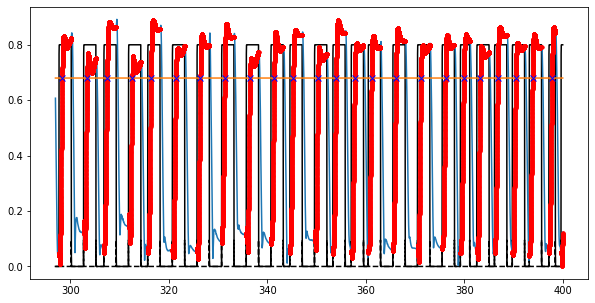

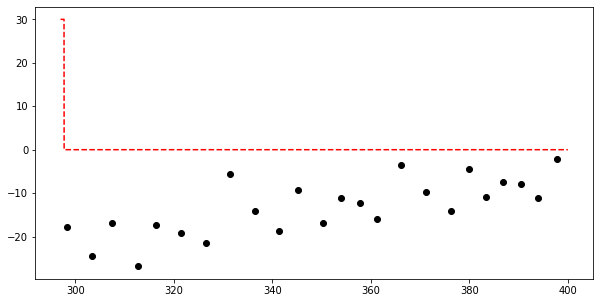

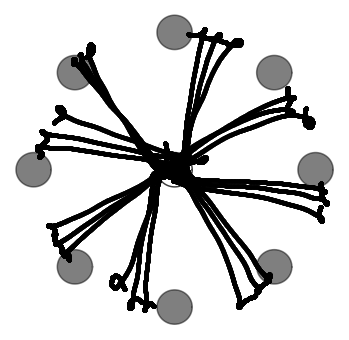

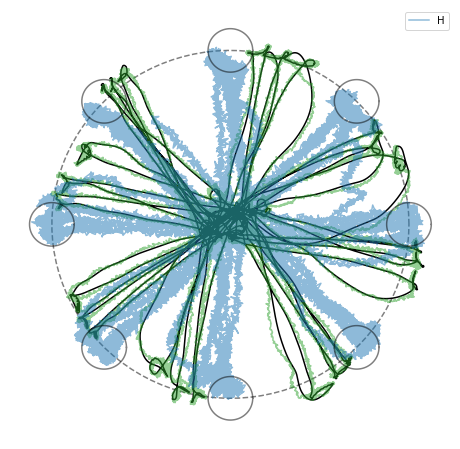

In [1303]:
ind0 = 297
indf = 400

hits, ang_err = get_angle_hit(probes_vmr, ind0, indf)
Cart_2Dplot(probes_vmr, v_or_p = 'v', ind0=ind0, indf = indf, hits=None)

# pos_vel_ctrl(probes_vmr, v_or_p = 'v', ind0=ind0, indf = indf) #[0 , 35], [37.5, 115], [240, 298], [297, 400]

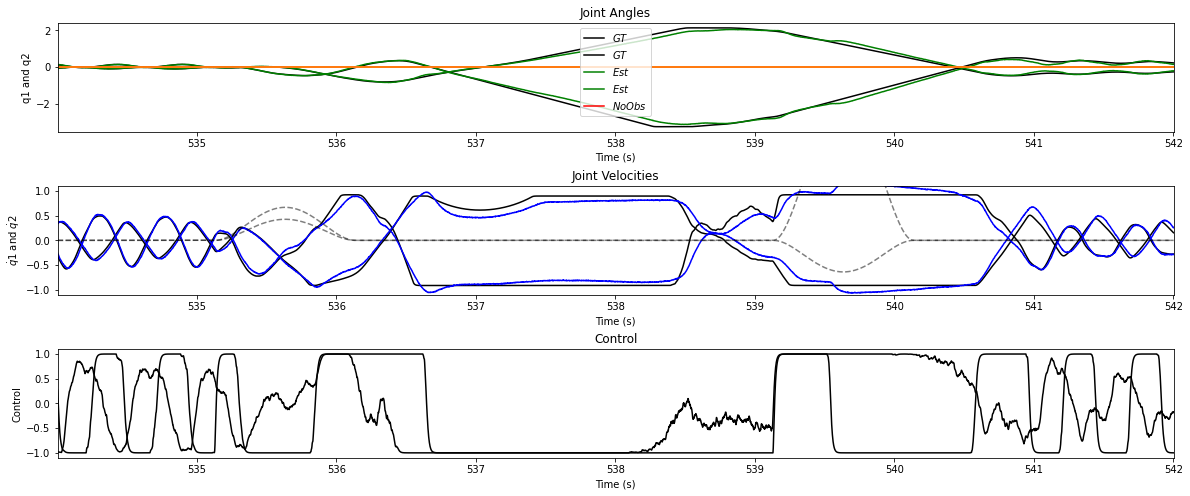

In [977]:
pos_vel_ctrl(probes_vmr, v_or_p = 'p', ind0=ind0, indf = indf)

XH shape is (750000, 4)


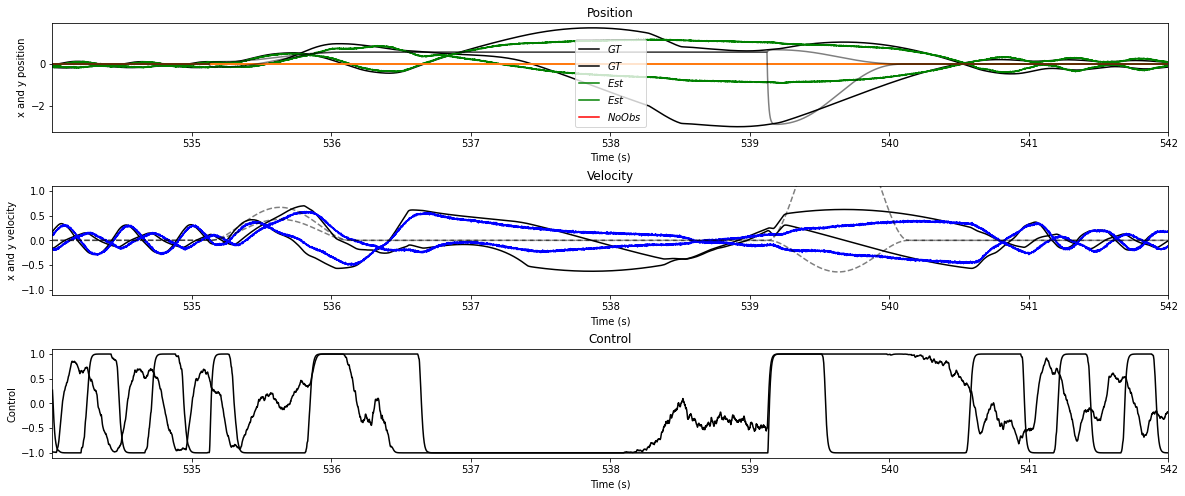

In [976]:
pos_vel_ctrl(probes_vmr, v_or_p = 'h', ind0=ind0, indf = indf)

XH shape is (25000, 4)


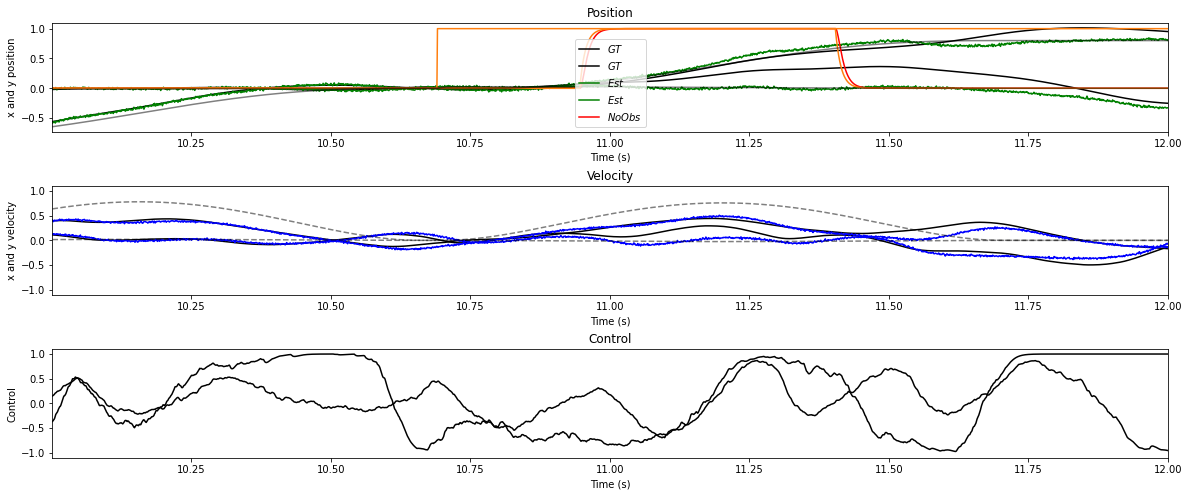

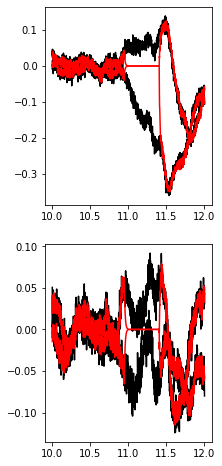

In [845]:
# ind0 = 0
# indf = 200

pos_vel_ctrl(probes_vmr, v_or_p = 'h', ind0=ind0, indf = indf)
p, T, Zv, Zp, Xv, Xp, Xh, U, No, Tar, Op, VMR, VwL, PwL, Hw, Aw, Herr = probes_vmr

fig, ax = plt.subplots(2, 1, figsize=(3, 8))

ax[0].plot(T[ind0*1000:indf*1000], Xh[ind0*1000:indf*1000,0:2] - Xv[ind0*1000:indf*1000,0:2], 'k', label='$GT$')
ax[0].plot(T[ind0*1000:indf*1000], -Herr[ind0*1000:indf*1000,0:2], 'r', label='$GT$')

ax[1].plot(T[ind0*1000:indf*1000], Xh[ind0*1000:indf*1000,2:4] - Xv[ind0*1000:indf*1000,2:4], 'k', label='$GT$')
ax[1].plot(T[ind0*1000:indf*1000], -Herr[ind0*1000:indf*1000,2:4], 'r', label='$GT$')


In [1281]:
# # Save Hw and probes_VMR
# p, T, Zv, Zp, Xv, Xp, Xh, U, No, Tar, Op, VMR, VwL, PwL, Hw, Aw, Herr = probes_vmr

# folder = 'data/'
# # import pickle
# # file_name = f'Hw_Th_s_{p.theta_s}_Th_u_{p.theta_u}_Qs_{p.qs}_Qu_{p.qu}_Lr_{p.Lr}_recurr_{p.recurr}_blindfrom_{p.blindfrom}_n_neurons_{p.n_neurons}.pkl'
# # with open(file_name, 'wb') as f:
# #     pickle.dump(Hw, f)

# # file_name = f'Aw.pkl'
# # with open(file_name, 'wb') as f:
# #     pickle.dump(Aw, f)

# file_name = f'p_and_probes_VMR_blindfrom_{p.blindfrom}_change.pkl'

with open(file_name, 'wb') as f:
    pickle.dump(probes_vmr, f)
    # Also save the variable
    str_to_save = f"p, T, Zv, Zp, Xv, Xp, Xh, U, No, Tar, Op, VMR, VwL, PwL, Hw, Aw, Herr= probes_VMR"
    f.write(str_to_save.encode('utf-8'))

# # save Vw and probes_vis
# import pickle
# file_name = f'VMR_Vwl_n_Pwl_change.pkl'
# with open(folder+file_name, 'wb') as f:
#     pickle.dump([VwL, PwL, Hw, Aw], f)


# Save probes
file_name = f'probes_VMR_change_30_B.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(probes_vmr, f)
    




In [1447]:
# # load VMR_Vwl_n_Pwl.pkl
# [Vwl, Pwl, Hw] = pickle.load(open('VMR_Vwl_n_Pwl.pkl', 'rb'))

### VMR endpoint error

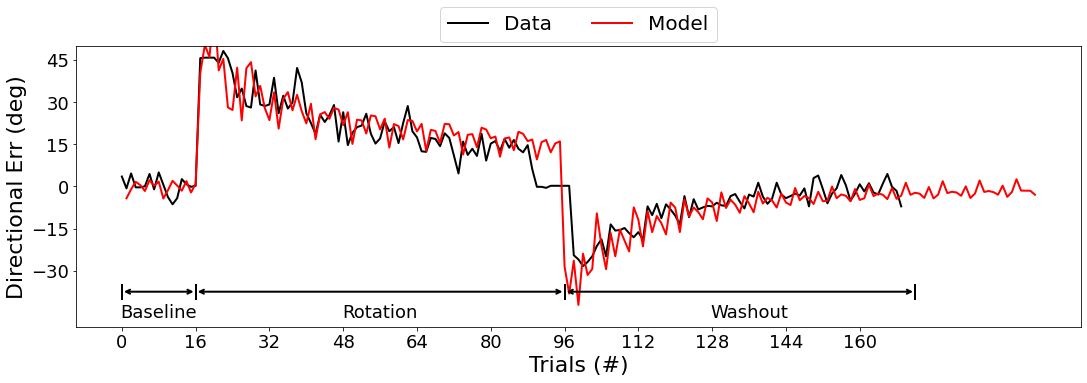

In [1199]:
# Load krakdata.npz 


def plot_trials(sim, probes, params, ang_err, offset_trials):
    """
    Plot trial directional error against krakauer data
    """
    import matplotlib.cm as cm

    # Gt, Up, Vp, Tp, TrajP, Vhatp, Vhatv, Phatp, Phatv, Hhatp, Hhatv, Pp, v_scale, u_scale, vmr_on, opqp, TnT, vmrt = probes
    
    # radius = 0.5
    # time = sim.trange()
    # Trials = sim.data[TnT][:,0] # of shape (n_steps, )
    # Home = sim.data[TnT][:,1] # of shape (n_steps, )
    # Act = sim.data[Gt]
    # Vis = sim.data[Vp]
    # Prop = sim.data[Pp]
    # Target = sim.data[Tp]

    # num_trials = int(max(Trials))
    # figHome, axHome = plt.subplots(1, 1, figsize=(10, 8))
    # thetas = np.linspace(0, 2*np.pi, 100)
    # axHome.plot(np.cos(thetas), np.sin(thetas), 'k')
    # axHome.set_xlim([-1.1, 1.1])
    # axHome.set_ylim([-1.1, 1.1])
    # # equal aspect ratio
    # axHome.set_aspect('equal', 'box')
    # axHome.set_title("Trials")

    # Theta_rel = np.zeros((num_trials, 1))
    # Theta_vmr = np.zeros((num_trials, 1))
    # vmr_theta_data = sim.data[vmrt]


    
    # # Change color as trial progresses
    # colors = cm.rainbow(np.linspace(0, 1, num_trials))
    # for i in range(1, num_trials+1):
    #     ind0 = np.where(Trials == i)[0][0]
    #     indf = np.where(Trials == i)[0][-1]

    #     # Check which part of the trial is not home
    #     this_trial = np.where(Home[ind0:indf] != 1)[0]
    #     axHome.plot(0,0, 'k')
        
    #     # if i == 17:
    #     #     print(f"Targ: {np.rad2deg(theta_target)}, Vis: {np.rad2deg(theta_vis)}")
    #     #     # Plot target
    #     #     axHome.plot(Target[ind0+this_trial,0], Target[ind0+this_trial,1], 'rx', label = "Target")
    #     #     axHome.plot(Vis[ind0+this_trial,0], Vis[ind0+this_trial,1], color=colors[i-1], label = "Trial")
    #     #     # Vision and Prop
    #     #     axHome.plot(Act[ind0+this_trial,0], Act[ind0+this_trial,1], 'r', label = "Gt")
    #     #     axHome.plot(Prop[ind0+this_trial,0], Prop[ind0+this_trial,1], 'b--', label = "Prop")

    #     # Check when the GT first hits the radius
    #     dist = np.linalg.norm(Act[ind0+this_trial,0:2], axis=1)
    #     try:
    #         ind_hit = np.where(dist >= 0.85*radius)[0][0]
    #     except:
    #         print(f"Trial {i} of {num_trials} did not hit the radius")
    #         ind_hit = -1
    #         # break
    #     axHome.plot(Vis[ind0+this_trial,0], Vis[ind0+this_trial,1], color=colors[i-1], label = "Trial")
    #     axHome.plot(Vis[ind0+this_trial[ind_hit],0], Vis[ind0+this_trial[ind_hit],1], 'ro', label="Hit")

    #     # Check the relative angle between GT and target from origin at ind_hit
    #     theta_vis = np.arctan2(Vis[ind0+this_trial[ind_hit],1], Vis[ind0+this_trial[ind_hit],0])
    #     theta_target = np.arctan2(Target[ind0+this_trial[ind_hit],1], Target[ind0+this_trial[ind_hit],0])
    #     theta_rel = np.rad2deg(theta_vis - theta_target)
    #     # If theta_rel is greater than 180, then subtract 360
    #     if theta_rel > 180:
    #         theta_rel = theta_rel - 360

        
    #     Theta_rel[i-1] = theta_rel 
    #     Theta_vmr[i-1] = np.rad2deg(vmr_theta_data[ind0+this_trial[ind_hit]])



    # trial_range = np.arange(1, num_trials+1)
    fig_vmr, ax_vmr = plt.subplots(1, 1, figsize=(18, 4))
    
    # Plot Data
    kdata = np.load("data/krakdata.npz")
    kerr = kdata['kerr']
    offset = kdata['offset']
    scale = kdata['scale']
    kerr = (kerr-offset)/scale
    kerr[:,0] = kerr[:,0]-24
    ax_vmr.plot(kerr[:,0]-1, kerr[:,1], 'k', label="Data", lw=2)
    
    trials_to_plot = np.arange(1, len(ang_err)+1) + offset_trials
    ax_vmr.plot(trials_to_plot, ang_err, 'r', label="Model", lw=2)


    # # Trials vs relative angle
    # ax_vmr.plot(trial_range, Theta_rel, 'r', label="Model", lw=2)
    # # ax_vmr.plot(trial_range, np.ones((num_trials, 1))*np.rad2deg(params.vmr_theta), 'k', label="VMR on")
    # ax_vmr.plot(trial_range, Theta_vmr, 'k--', label="Rotation", lw=2)

    # Legend on top of figure
    ax_vmr.legend(loc='upper center', bbox_to_anchor=(0.5, 1.175), ncol=3, fancybox=True, fontsize=20)
    # Increase x, y ticks font size
    ax_vmr.tick_params(axis='both', which='major', labelsize=18)

    # Increase x ticks by 16 and y ticks by 15
    ax_vmr.set_xticks(np.arange(0, 170, 16))
    ax_vmr.set_yticks(np.arange(-30, 45.1, 15))
    # Make the last tick visible in y axis
    ax_vmr.set_ylim([-50, 50])

    # Set x, y labels
    ax_vmr.set_xlabel("Trials (#)", fontsize=22)
    ax_vmr.set_ylabel("Directional Err (deg)", fontsize=22)
    plt.subplots_adjust(top=1.1)

    # baseline
    ax_vmr.annotate("", xy=(0, -37.5), xytext=(16, -37.5), arrowprops=dict(arrowstyle="<->", color='k', lw=2))
    ax_vmr.annotate("Baseline", xy=(8, -45), ha='center', va='center', fontsize=18)
    # Add vertical line at the end of arrows
    ax_vmr.plot([0, 0], [-40, -35], 'k', lw=2); ax_vmr.plot([16, 16], [-40, -35], 'k', lw=2)

    # Rotation from 16 to 96
    ax_vmr.annotate("", xy=(16, -37.5), xytext=(96, -37.5), arrowprops=dict(arrowstyle="<->", color='k', lw=2))
    ax_vmr.annotate("Rotation", xy=(56, -45), ha='center', va='center', fontsize=18)    
    # Add vertical line at the end of arrows
    ax_vmr.plot([16, 16], [-40, -35], 'k', lw=2); ax_vmr.plot([96, 96], [-40, -35], 'k', lw=2)

    # Washout from 96 to 172
    ax_vmr.annotate("", xy=(96, -37.5), xytext=(172, -37.5), arrowprops=dict(arrowstyle="<->", color='k', lw=2))
    ax_vmr.annotate("Washout", xy=(136, -45), ha='center', va='center', fontsize=18)
    # Add vertical line at the end of arrows
    ax_vmr.plot([96, 96], [-40, -35], 'k', lw=2); ax_vmr.plot([172, 172], [-40, -35], 'k', lw=2)

    
plot_trials(0,0,0, ang_err, 16 - p.rot_start)

In [1285]:

def load_model(save_name):
    with open(save_name, 'rb') as f:
        probes_VMR = pickle.load(f)
    return probes_VMR


probes_vmr = load_model(f"data\probes_VMR_change_30.pkl")
p, T, Zv, Zp, Xv, Xp, Xh, U, No, Tar, Op, VMR, VwL, PwL, Hw, Aw, Herr = probes_vmr

### Rotation trajectories against data

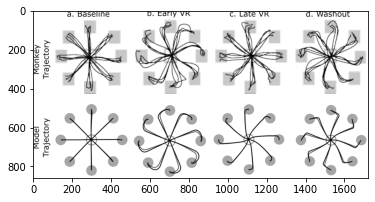

In [1219]:
# Open png and plot on top of it
from PIL import Image
import matplotlib.pyplot as plt

traj_path = "C:\\Users\\Nat\\Documents\\Code\\Thesis\\data\\trajectory_2.png"

img = plt.imread(traj_path)

implot = plt.imshow(img)


Distance to target is 0.68 = 0.8 - 0.05
Hit indices are [ 1322  3694  5903  8273 10584 12711 15141 18501]


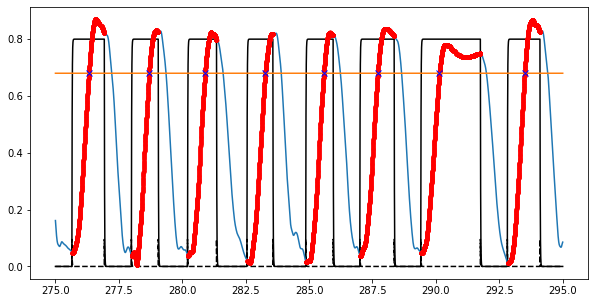

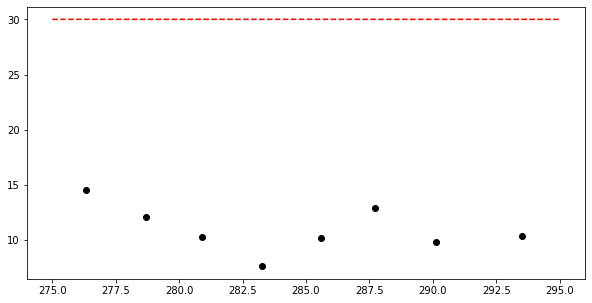

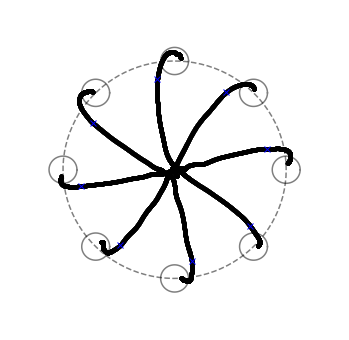

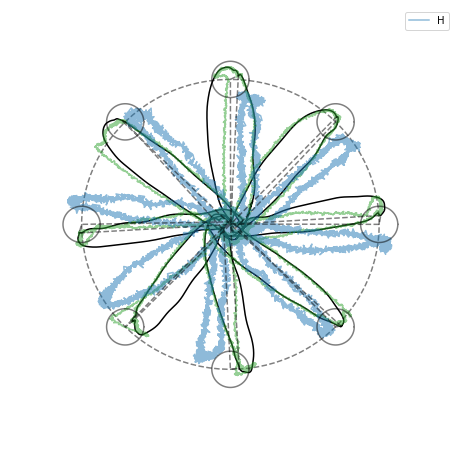

In [1222]:
ind0 = 275
indf = 295

hits, ang_err = get_angle_hit(probes_vmr, ind0, indf)
Cart_2Dplot(probes_vmr, v_or_p = 'v', ind0=ind0, indf = indf, hits=None)

# pos_vel_ctrl(probes_vmr, v_or_p = 'v', ind0=ind0, indf = indf)